Este notebook servirá para calcular la masa del solitón para unos parámetros dados y obtener un cierto conjunto de gráficas (principalmente las densidades de energía). Además, luego sacaremos lo análogo para los momentos de inercia.

Para ver en más detalle cómo funciona, ir al notebook de Buscaminimos.

In [ ]:
#Importamos las librerias.
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import scipy.integrate as integrate

#Proporciones y tamaños en las graficas.
params = {'xtick.labelsize': 30, 'ytick.labelsize': 20, 'font.size': 30}#
mpl.rcParams.update(params)

#Constantes para el calculo (en MeV o adimensionales).
F_pi_val = 108 # o 104.8 o 186
e_val = 4.648 # o 4.84
m_pi = 138
alpha = 0.0444
m_rho = 796
kapp_inv = 0.1886 /(np.pi**2/np.sqrt(3))

#Valores correctos
M_N_corr = 939 #MeV
M_D_corr = 1232 #MeV
r_bar_corr = 0.72 #fm

#Factores de conversion de longitud y energia.
Factor_l = (2/(e_val *F_pi_val))
Factor_e = F_pi_val/(4*e_val)* (12*np.pi**2)

convers = 806554.815355*10**6 * (2*np.pi) #1MeV = ... m^-1

n_r = 500 #500
r_f = 30. #30
n_lam = 100 #100
lam_f = np.sqrt(53.4570253 / (4*6.336630541)) + 0.5

rs = np.linspace(1e-6, r_f, n_r)* Factor_l
rs2 = np.linspace(1e-6, r_f, 2000)* Factor_l
lams3 = np.linspace((lam_f-0.5*2), lam_f, 4)**2* Factor_l**2
lams = np.linspace((lam_f-0.5*2), lam_f, n_lam)**2* Factor_l**2

In [ ]:
@njit
def Mskyrme(F_pi_val, lam, m_pi, e_val):
    return 6.336630541*F_pi_val**2*np.sqrt(lam) + 53.4570253/(e_val**2*np.sqrt(lam))# + 2*np.pi*73.5595*F_pi_val**2*m_pi**2 *np.sqrt(lam)**3

1.243206293091898


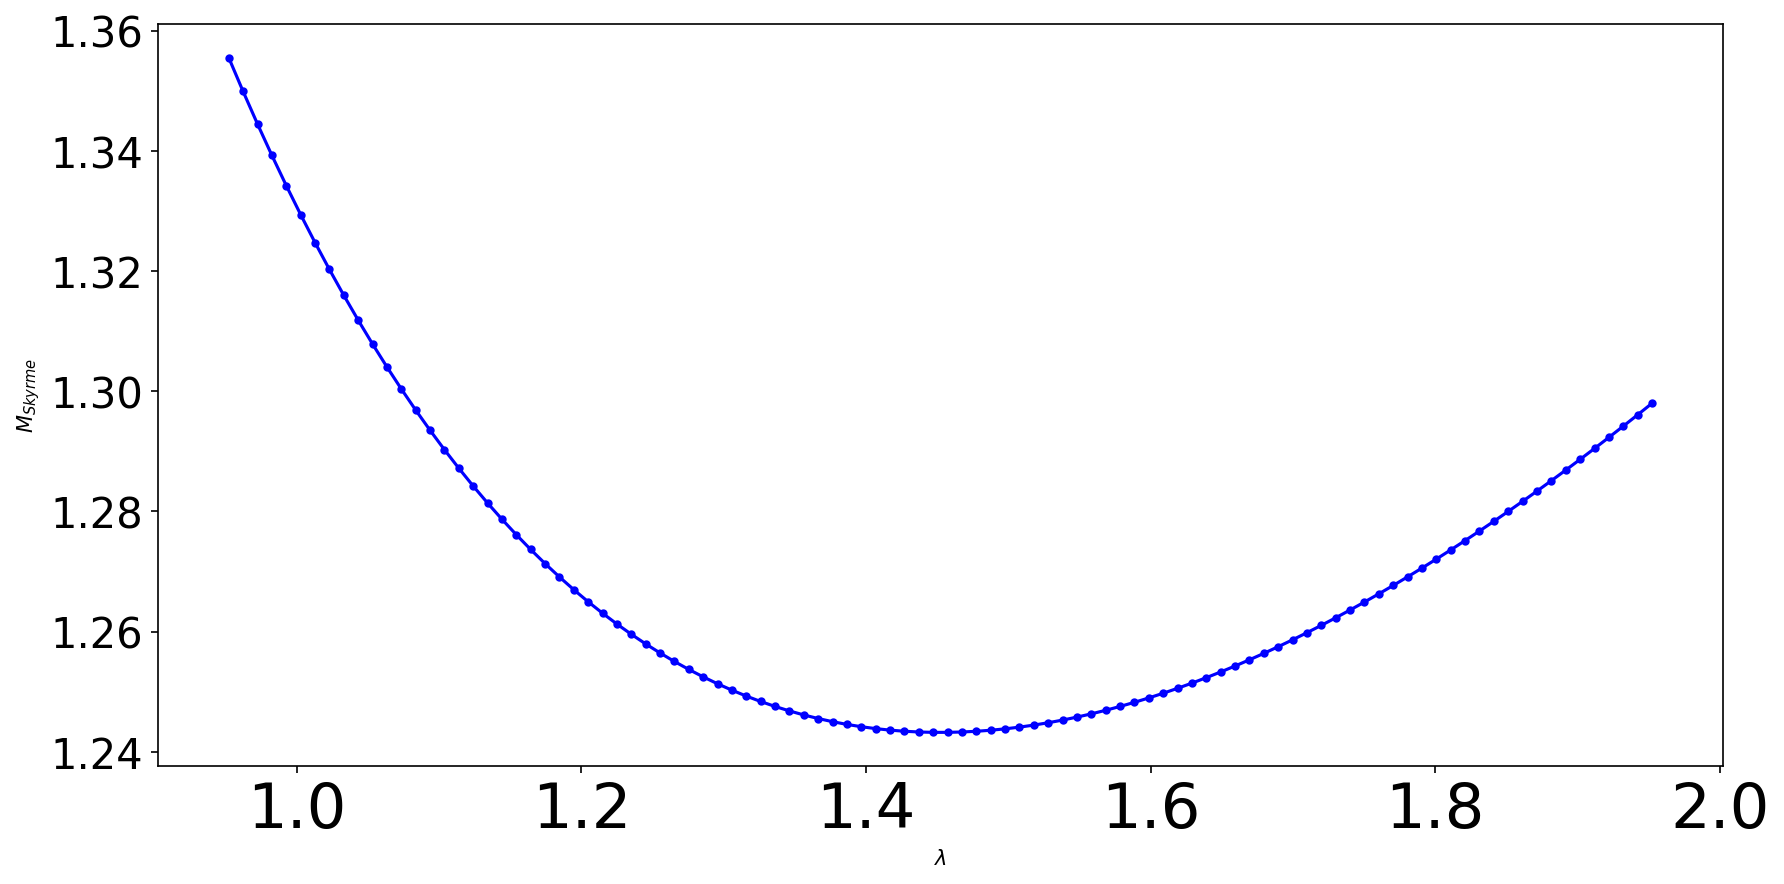

In [ ]:
Masas_skyrme = np.array([Mskyrme(F_pi_val, _lam, m_pi, e_val) for _lam in lams])/Factor_e
print(min(Masas_skyrme))

plt.figure('MasasSkyrme', figsize=(12, 6), dpi=150)
plt.plot(np.sqrt(lams)/ Factor_l, Masas_skyrme, '.-b')

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$M_{Skyrme}$')
plt.tight_layout(); plt.show()

Densidad radial de energía.

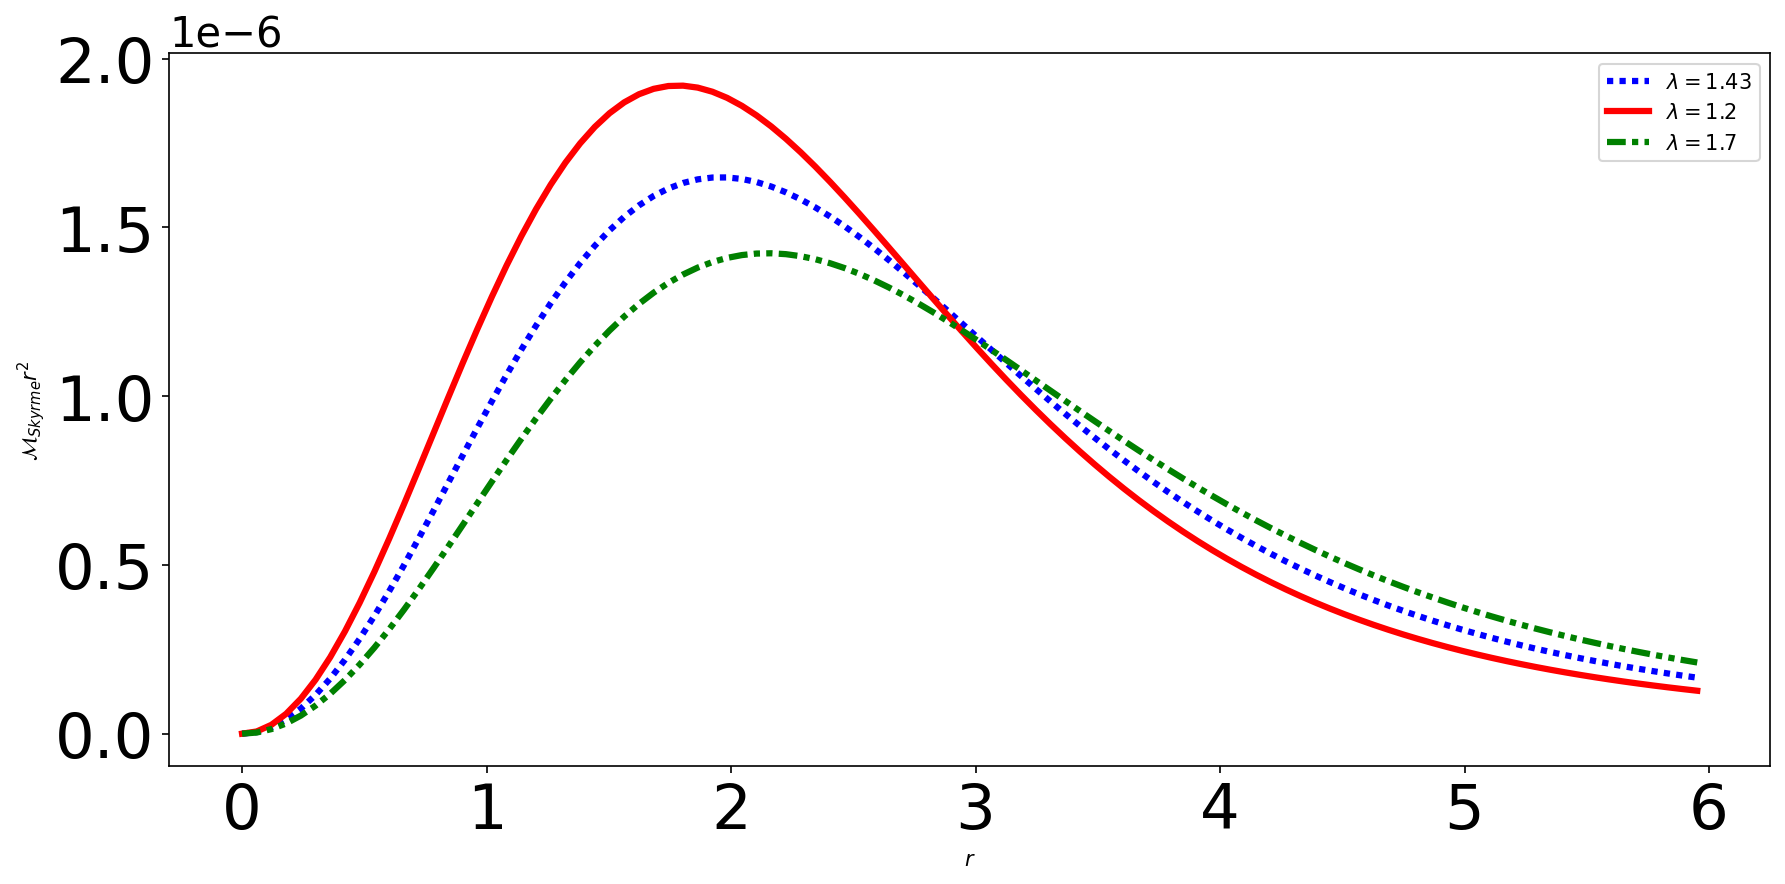

In [ ]:
@njit
def Mskyrmr(r, F_pi_val, lam, m_pi, e_val):
    a = (lam+r*r); sinus = np.sin(np.pi * r / np.sqrt(a))**2
    return (F_pi_val**2 / 4 * ( np.pi**2 * lam**2 / 2*a**3 + sinus/r**2) + ( np.pi**2 * lam**2 * sinus/a**3 + sinus**2 /(2*r*r) ) / (e_val*r)**2)*r**2

Masas_skyrmer1 = np.array([Mskyrmr(_r, F_pi_val, 1.43*Factor_l**2, m_pi, e_val) for _r in rs2])/Factor_e * Factor_l**3
Masas_skyrmer2 = np.array([Mskyrmr(_r, F_pi_val, 1.2*Factor_l**2, m_pi, e_val) for _r in rs2])/Factor_e * Factor_l**3
Masas_skyrmer3 = np.array([Mskyrmr(_r, F_pi_val, 1.7*Factor_l**2, m_pi, e_val) for _r in rs2])/Factor_e * Factor_l**3

plt.figure('MasasSkyrme', figsize=(12, 6), dpi=150)
plt.plot(rs[:int(len(rs2)/20)] / Factor_l, Masas_skyrmer1[:int(len(rs2)/20)], 'b', linestyle = (0, (1, 1)), label = r'$\lambda=${}'.format(1.43), linewidth=3)
plt.plot(rs[:int(len(rs2)/20)] / Factor_l, Masas_skyrmer2[:int(len(rs2)/20)], '-r', label = r'$\lambda=${}'.format(1.2), linewidth=3)
plt.plot(rs[:int(len(rs2)/20)] / Factor_l, Masas_skyrmer3[:int(len(rs2)/20)], '-g', linestyle = (0, (3, 1, 1, 1, 1, 1)), label = r'$\lambda=${}'.format(1.7), linewidth=3)

plt.xlabel(r'$r$'); plt.ylabel(r'$\mathcal{M}_{Skyrme} r^2$')
plt.yticks(fontsize=30)
plt.legend(loc= 'upper right')
plt.tight_layout(); plt.show()

In [ ]:
@njit
def eta(h, r, lam): return h/(h**2+r**2+lam)
@njit
def zeta(h, r, lam): return -r/(h**2+r**2+lam)
@njit
def pm(h): return 0.5 + 0.5*math.erf( h / np.sqrt(2.) )
@njit
def p0(h): return np.exp(-0.5*h*h) / np.sqrt(np.sqrt(np.pi))
@njit
def f(r, lam): return - np.pi / np.sqrt( 1. + lam / (r*r) )
@njit
def F(h, r, lam): return  - 0.5 * r * ( np.pi + 2.*math.atan( h / np.sqrt(r**2+lam) ) )/ (np.sqrt(r**2+lam))
@njit
def k1(h, r, lam): return ( eta(h, r, lam)*np.cos(2*F(h, r, lam)) - (zeta(h, r, lam)+0.5/r)*np.sin(2*F(h, r, lam)) + 0.5*np.sin(2*f(r, lam))*pm(h)/r ) * p0(h)
@njit
def Fdiff(h, r, lam): return  F(h, r, lam) *( 1./r - r/(lam+r*r)) + eta(h, r, lam)*r*r/(lam+r*r)
@njit
def k2(h, r, lam): return ( eta(h, r, lam) -  Fdiff(h, r, lam)   + f(r, lam) * (1 - (f(r, lam) /np.pi )**2 ) / r  * pm(h) )*p0(h)
@njit
def k3(h, r, lam): return ( eta(h, r, lam)*np.sin(2*F(h, r, lam)) + \
            (zeta(h, r, lam)+0.5/r)*np.cos(2*F(h, r, lam)) -\
            0.5/r - 0.5*( np.cos(2*f(r, lam)) - 1 )*pm(h)/r ) *p0(h)
@njit
def ki(h, r, lam):
    etav = eta(h, r, lam); zetav = zeta(h, r, lam); Fdiffv = Fdiff(h, r, lam); Fv = 2*F(h, r, lam); fv = f(r, lam)
    pmv = pm(h); p0v = p0(h)

    k1val = ( etav*np.cos(Fv) - (zetav+0.5/r)*np.sin(Fv) + 0.5*np.sin(2*fv)*pmv/r ) * p0v
    k2val = ( etav -  Fdiffv   + fv * (1 - (fv /np.pi )**2 ) / r  * pmv )*p0v
    k3val =  ( etav*np.sin(Fv) +  (zetav+0.5/r)*np.cos(Fv) - 0.5/r - 0.5*( np.cos(2*fv) - 1 )*pmv/r ) *p0v
    return k1val, k2val, k3val

In [ ]:
k1_r_lam = np.array([ [ integrate.quad(lambda h: k1(h, r=_r, lam=_l), -np.inf, np.inf)[0] for _r in rs ] for _l in lams ])
k2_r_lam = np.array([ [ integrate.quad(lambda h: k2(h, r=_r, lam=_l), -np.inf, np.inf)[0] for _r in rs ] for _l in lams ])
k3_r_lam = np.array([ [ integrate.quad(lambda h: k3(h, r=_r, lam=_l), -np.inf, np.inf)[0] for _r in rs ] for _l in lams ])

k1_r_lam2 = np.array([ [ integrate.quad(lambda h: k1(h, r=_r, lam=_l), -np.inf, np.inf)[0] for _r in rs2 ] for _l in lams3 ])
k2_r_lam2 = np.array([ [ integrate.quad(lambda h: k2(h, r=_r, lam=_l), -np.inf, np.inf)[0] for _r in rs2 ] for _l in lams3 ])
k3_r_lam2 = np.array([ [ integrate.quad(lambda h: k3(h, r=_r, lam=_l), -np.inf, np.inf)[0] for _r in rs2 ] for _l in lams3 ])

Densidad radial de $k_i$

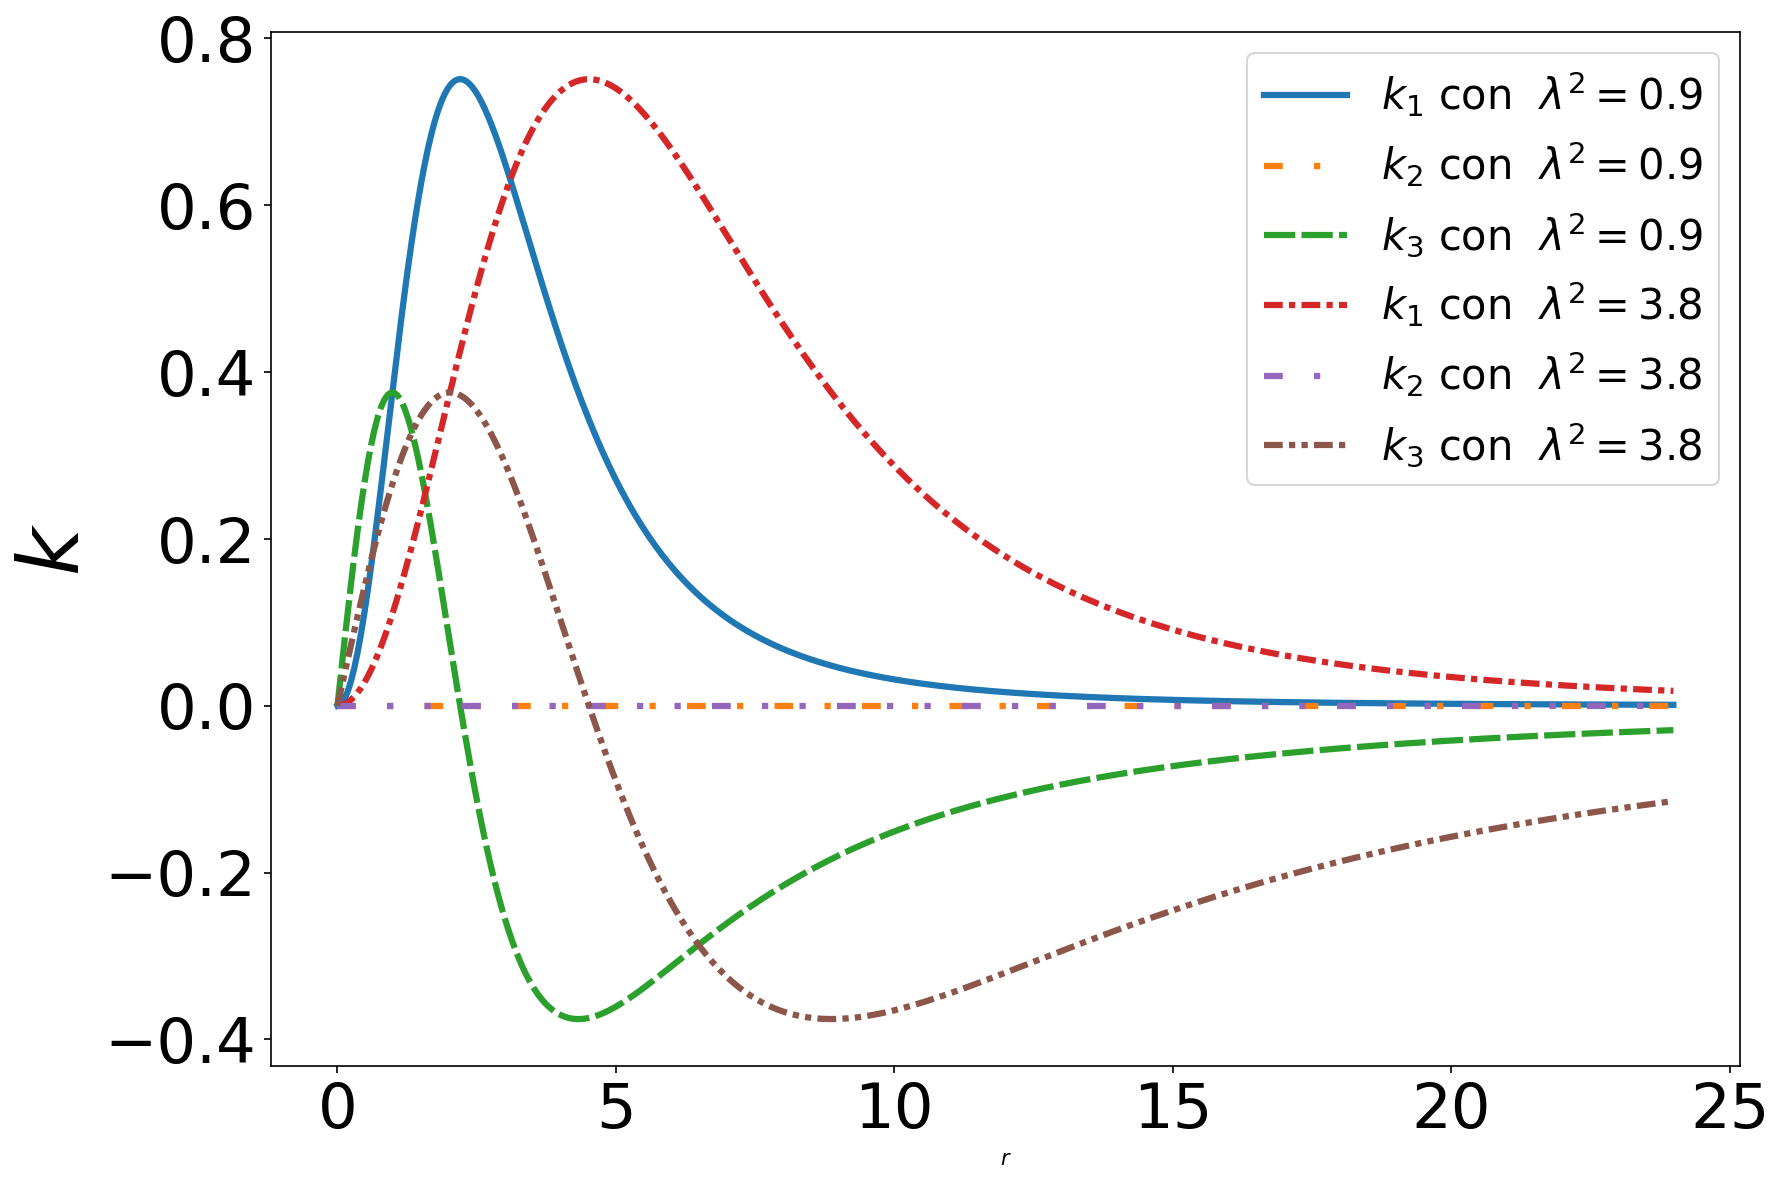

In [ ]:
plt.figure('ki frente a r', figsize=(12, 8), dpi = 150)
plt.plot(rs[:int(len(rs2)/5)] / Factor_l, k1_r_lam2[0][:int(len(rs2)/5)], '-', label=r'$k_1$ con  $\lambda^2=${}'.format(round(lams[0]/Factor_l**2, 1)), linewidth=3)
plt.plot(rs[:int(len(rs2)/5)] / Factor_l, k2_r_lam2[0][:int(len(rs2)/5)], linestyle=(0, (3, 5, 1, 5)), label=r'$k_2$ con  $\lambda^2=${}'.format(round(lams[0]/Factor_l**2, 1)), linewidth=3)
plt.plot(rs[:int(len(rs2)/5)] / Factor_l, k3_r_lam2[0][:int(len(rs2)/5)], linestyle=(0, (5, 1)), label=r'$k_3$ con  $\lambda^2=${}'.format(round(lams[0]/Factor_l**2, 1)), linewidth=3)
plt.plot(rs[:int(len(rs2)/5)] / Factor_l, k1_r_lam2[-1][:int(len(rs2)/5)], linestyle=(0, (3, 1, 1, 1)), label=r'$k_1$ con  $\lambda^2=${}'.format(round(lams[-1]/Factor_l**2, 1)), linewidth=3)
plt.plot(rs[:int(len(rs2)/5)] / Factor_l, k2_r_lam2[-1][:int(len(rs2)/5)], linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'$k_2$ con  $\lambda^2=${}'.format(round(lams[-1]/Factor_l**2, 1)), linewidth=3)
plt.plot(rs[:int(len(rs2)/5)] / Factor_l, k3_r_lam2[-1][:int(len(rs2)/5)], linestyle=(0, (3, 1, 1, 1, 1, 1)), label=r'$k_3$ con  $\lambda^2=${}'.format(round(lams[-1]/Factor_l**2, 1)), linewidth=3)
plt.xlabel(r'$r$'); plt.ylabel(r'$k$', fontsize=40)
plt.legend(loc='upper right', fontsize = 20)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.show()

In [ ]:
@njit
def M4_dif(k11, k12, k31, k32, dr, r):
    dk1 = (k12-k11)/dr; dk3 = (k32-k31)/dr; k1r = (k12+k11)/2; k3r = (k32+k31)/2#Definimos tanto las derivadas (dk1, dk3) como los valores medios entre los dos puntos(k1r, k3r)
    return (k1r + r*dk1)**2 + 3*k3r**2 + 2*r*k3r*dk3 + dk3**2 * r**2
@njit
def M5_dif(k1, k3, r): return (k1**2 + k3**2)*r**2
@njit
def M6_dif(k31, k32, dr, r, lam):
    dk3 = (k32-k31)/dr; k3r = (k32+k31)/2; a = np.sqrt(lam+r**2)
    return np.sin(np.pi*r/a) / (r*a**3) * ( 2*np.pi*lam*r*(k3r+r*dk3)  + k3r*a**3*np.sin(2*np.pi*r/a) )
@njit
def integrador4(k1, k3, rs):
    dr = rs[1] - rs[0]; M4 = 0
    for i in range(len(rs)-1): M4 += M4_dif(k1[i], k1[i+1], k3[i], k3[i+1], dr, (rs[i]+rs[i+1])/2 ) * dr#Vamos a cada punto y evaluamos el integrando
    return M4*4.*np.pi
@njit
def integrador5(k1, k3, rs):
    dr = rs[2] - rs[1]; M5 = 0
    for i in range(len(rs)): M5 += M5_dif(k1[i], k3[i], rs[i]) * dr#Vamos a cada punto y evaluamos el integrando
    return M5*4.*np.pi
@njit
def integrador6(k3, rs, lam):
    dr = rs[2] - rs[1]; M6 = 0
    for i in range(len(rs)-1): M6 += M6_dif( k3[i], k3[i+1], dr, (rs[i]+rs[i+1])/2, lam ) * dr#Vamos a cada punto y evaluamos el integrando
    return M6*16.*np.pi
@njit
def M7(F_pi_val, lam, kapp_inv): return 4*np.pi**3 * 1.35209 * kapp_inv**2/ (np.sqrt(lam)**3 *F_pi_val**2)

@njit
def dens_M7(F_pi_val, lam, kapp_inv, r): return 4*np.pi**3*kapp_inv**2 *lam/(F_pi_val**2) * np.sin(np.pi*r/np.sqrt(lam+r*r))**4 / (r*r*(r*r+lam)**3)

Densidad radial de energía.

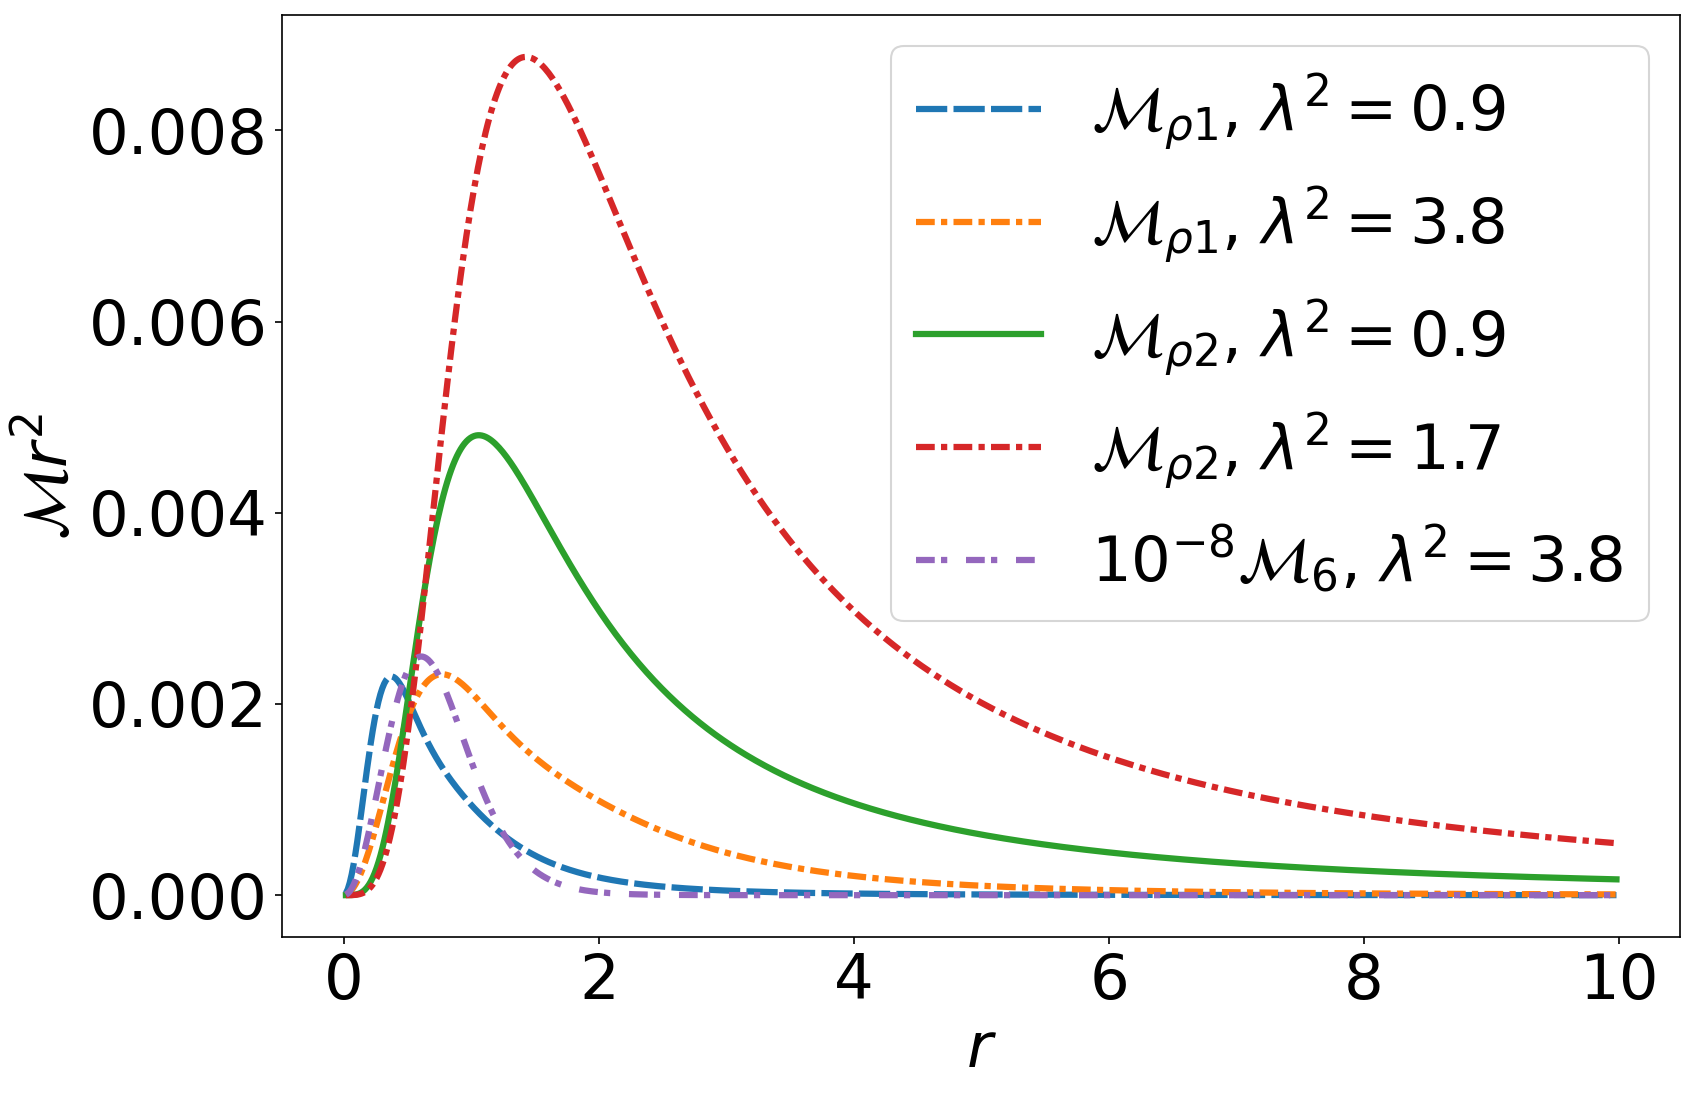

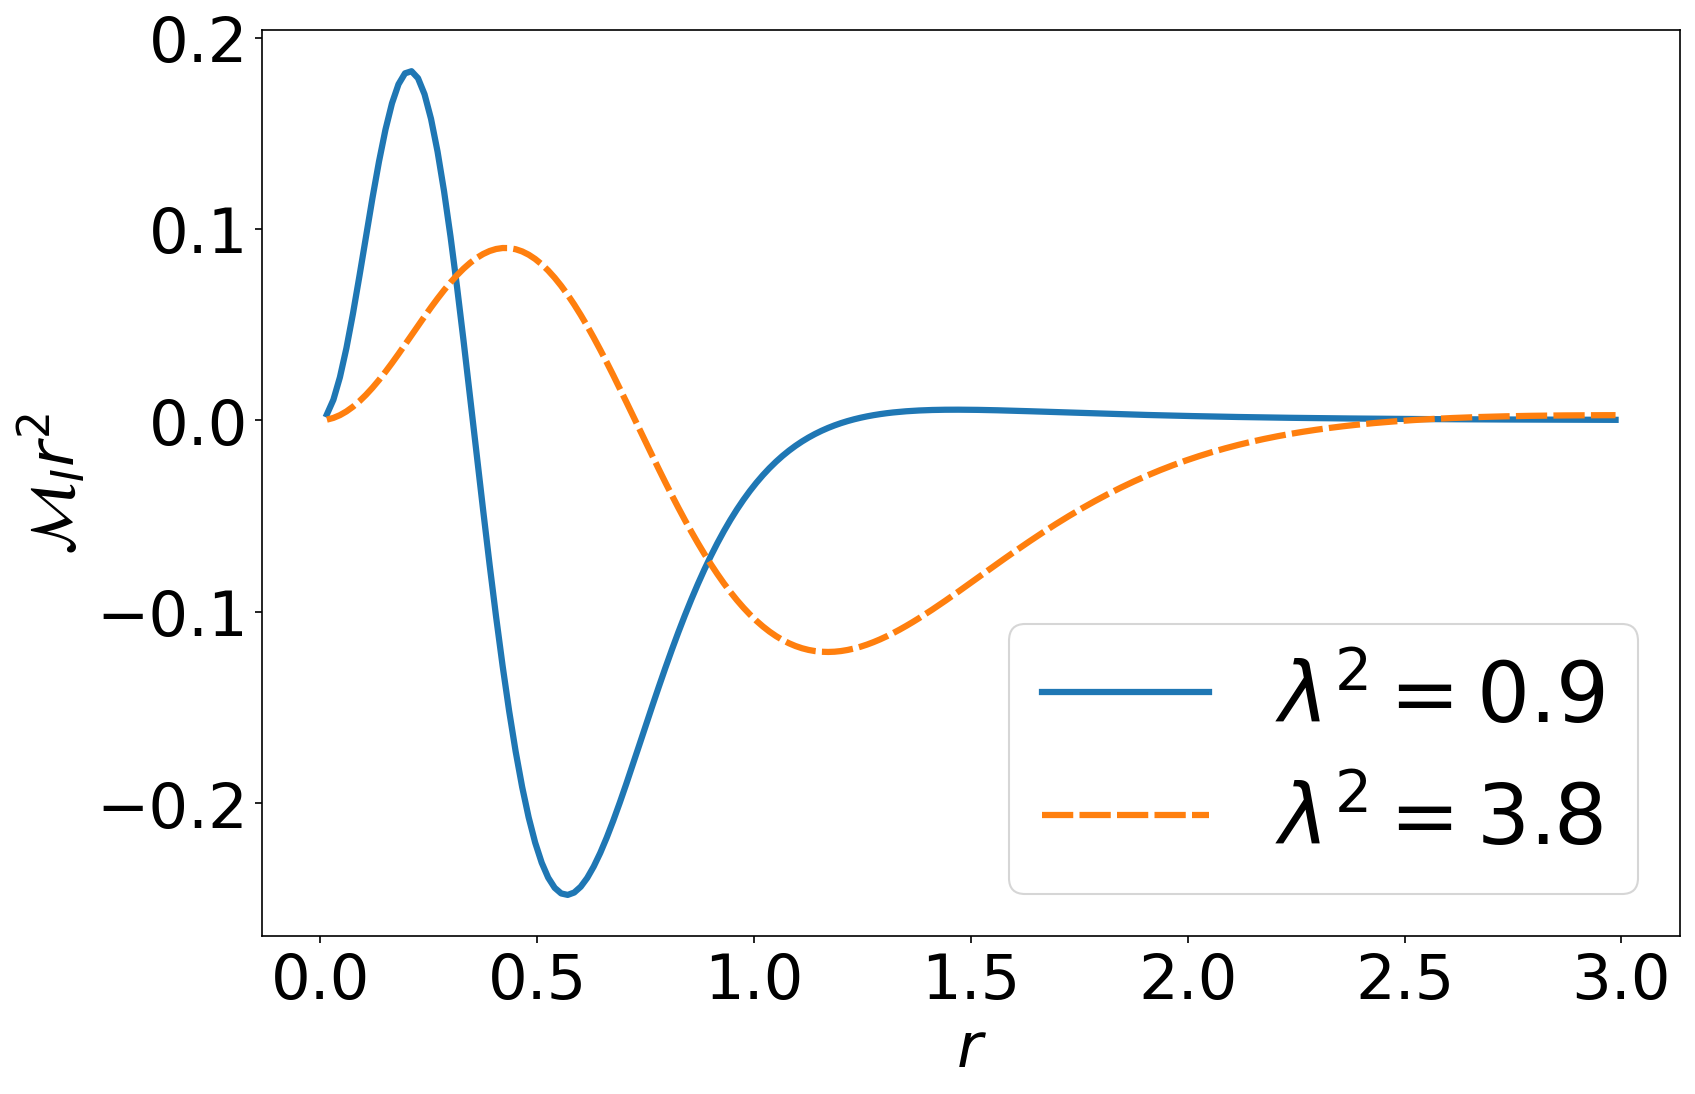

In [ ]:
dr2 = rs2[1] - rs2[0]
M_r4 = np.array([ M4_dif(k1_r_lam2[0][_r], k1_r_lam2[0][_r+1], k3_r_lam2[0][_r], k3_r_lam2[0][_r+1], dr2, rs2[_r]) for _r in range(len(rs2)-1) ])/Factor_e
M_r42 = np.array([ M4_dif(k1_r_lam2[-1][_r], k1_r_lam2[-1][_r+1], k3_r_lam2[-1][_r], k3_r_lam2[-1][_r+1], dr2, rs2[_r]) for _r in range(len(rs2)-1) ])/Factor_e
M_r5 = m_rho**2*np.array([ M5_dif(k1_r_lam2[0][_r], k3_r_lam2[0][_r], rs2[_r]) for _r in range(len(rs2)-1) ])/Factor_e
M_r52 = m_rho**2*np.array([ M5_dif(k1_r_lam2[int(len(lams3)/4)][_r],  k3_r_lam2[int(len(lams3)/4)][_r], rs2[_r]) for _r in range(len(rs2)-1) ])/Factor_e
M_r61 = alpha*4*np.array([ M6_dif(k3_r_lam2[0][_r], k3_r_lam2[0][_r+1], dr2, rs2[_r], lams3[0]) for _r in range(len(rs2)-1) ])/Factor_e
M_r62 = alpha*4*np.array([ M6_dif(k3_r_lam2[-1][_r], k3_r_lam2[-1][_r+1], dr2, rs2[_r], lams3[-1]) for _r in range(len(rs2)-1) ])/Factor_e
M_7_dif = np.array([ dens_M7(F_pi_val, lams3[-1], kapp_inv, rs2[_r]) for _r in range(len(rs2)-1) ])/Factor_e

labels2 = [ ', $\lambda^2=${0}'.format(round(lams3[0]/Factor_l**2, 1)), ', $\lambda^2=${0}'.format(round(lams3[-1]/Factor_l**2, 1))]
labels3 = [ ', $\lambda^2=${0}'.format(round(lams3[0]/Factor_l**2, 1)), ', $\lambda^2=${0}'.format(round(lams3[int(len(lams3)/4)]/Factor_l**2, 1))]
plt.figure('Mi frente a r', figsize=(12, 8), dpi = 150)
plt.plot(rs2[1:int(len(rs2)/3)] / Factor_l, M_r4[1:int(len(rs2)/3)], linestyle=(0, (5, 1)), label=r'$\mathcal{M}_{\rho 1}$'+labels2[0], linewidth=3)
plt.plot(rs2[1:int(len(rs2)/3)] / Factor_l, M_r42[1:int(len(rs2)/3)], linestyle=(0, (3, 1, 1, 1)), label=r'$\mathcal{M}_{\rho 1}$'+labels2[1], linewidth=3)

plt.plot(rs2[1:int(len(rs2)/3)] / Factor_l, M_r5[1:int(len(rs2)/3)], '-',label=r'$\mathcal{M}_{\rho 2}$'+labels3[0], linewidth=3)
plt.plot(rs2[1:int(len(rs2)/3)] / Factor_l, M_r52[1:int(len(rs2)/3)], linestyle=(0, (3, 1, 1, 1)), label=r'$\mathcal{M}_{\rho 2}$'+labels3[1], linewidth=3)

plt.plot(rs2[1:int(len(rs2)/3)] / Factor_l, M_7_dif[1:int(len(rs2)/3)]/10**8, linestyle=(0, (3, 1, 1, 3)), label=r'$10^{-8}\mathcal{M}_6$'+labels2[1], linewidth=3)
plt.xlabel(r'$r$'); plt.ylabel(r'$\mathcal{M} r^2$')
plt.yticks(fontsize=30)
plt.legend(loc='upper right', fontsize = 30)
plt.tight_layout(); plt.show()


labels2 = [ '$\lambda^2=${0}'.format(round(lams[0]/Factor_l**2, 1)), '$\lambda^2=${0}'.format(round(lams[-1]/Factor_l**2, 1))]
plt.figure('M6 frente a r', figsize=(12, 8), dpi = 150)
plt.plot(rs2[1:int(len(rs2)/10)] / Factor_l, M_r61[1:int(len(rs2)/10)], '-', label=labels2[0], linewidth=3)
plt.plot(rs2[1:int(len(rs2)/10)] / Factor_l, M_r62[1:int(len(rs2)/10)], linestyle=(0, (5, 1)), label=labels2[1], linewidth=3)
plt.xlabel(r'$r$'); plt.ylabel(r'$\mathcal{M}_I r^2$')
plt.yticks(fontsize=30)
plt.legend(loc='lower right', fontsize = 40)
plt.tight_layout(); plt.show()

In [ ]:
M4 = np.array( [ integrador4(k1_r_lam[_], k3_r_lam[_], rs) for _ in range(n_lam) ] )/Factor_e
M5 = m_rho**2 * np.array( [ integrador5(k1_r_lam[_], k3_r_lam[_], rs) for _ in range(n_lam) ] )/Factor_e
M6 = alpha*np.array( [ integrador6(k3_r_lam[_], rs, lams[_]) for _ in range(n_lam) ] )/Factor_e

n_lam2 = 400
lam_f2 = np.sqrt(53.4570253 / (4*6.336630541)) + 2
lams2 = np.linspace((lam_f2-2*2)**2, lam_f2**2, n_lam2)* Factor_l**2

Masas_7 = np.array([M7(F_pi_val,  _lam, kapp_inv) for _lam in lams2]) / Factor_e
Masas_skyrme2 = np.array([Mskyrme(F_pi_val, _lam, m_pi, e_val) for _lam in lams2])/Factor_e

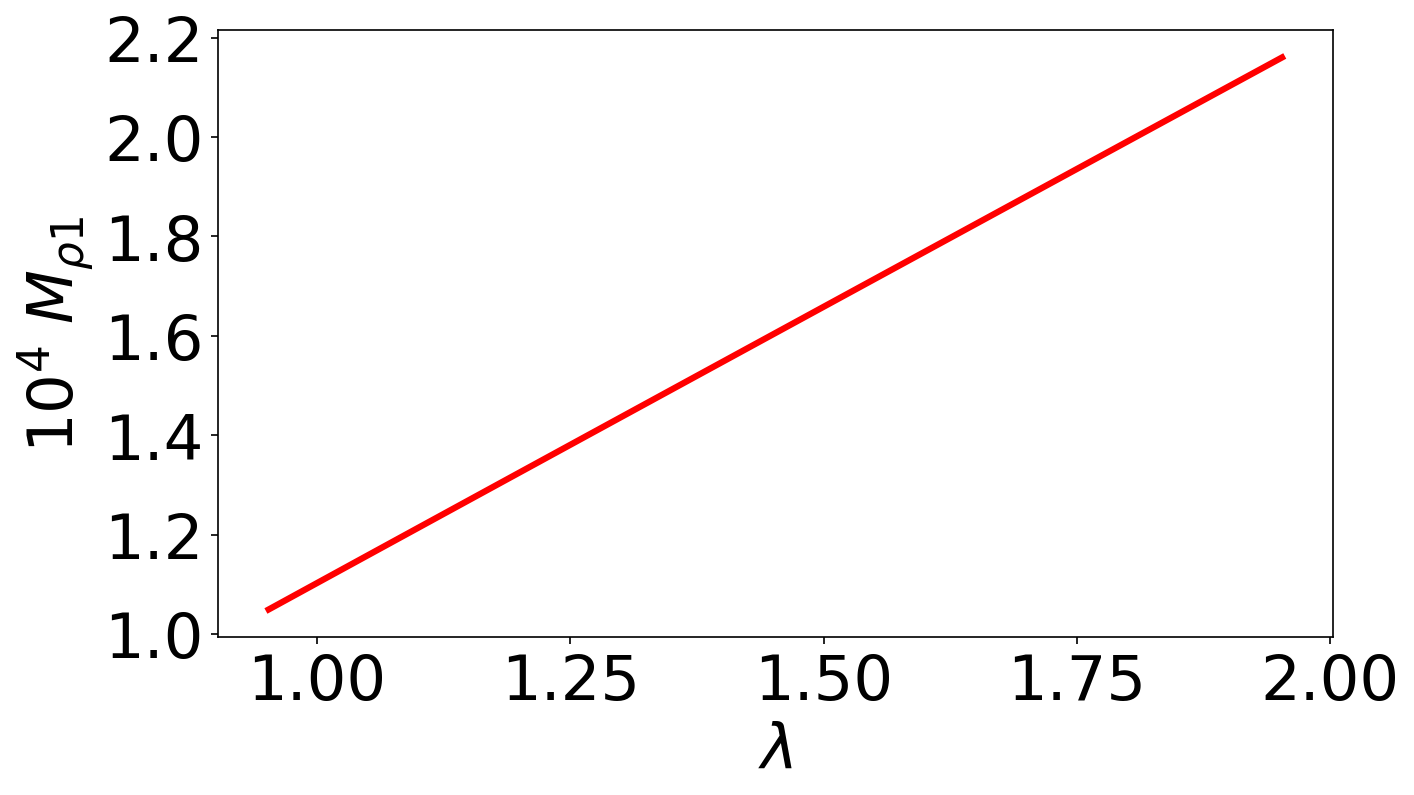

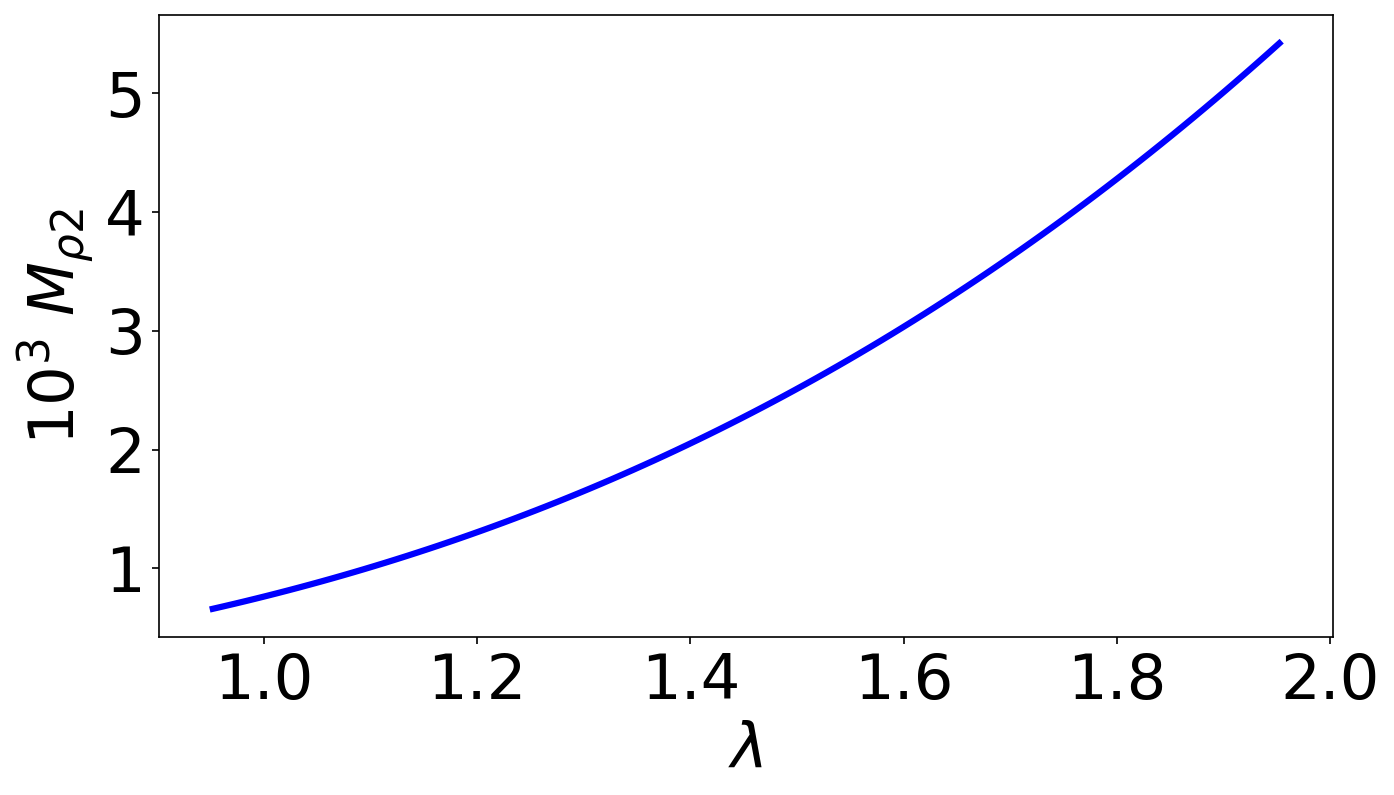

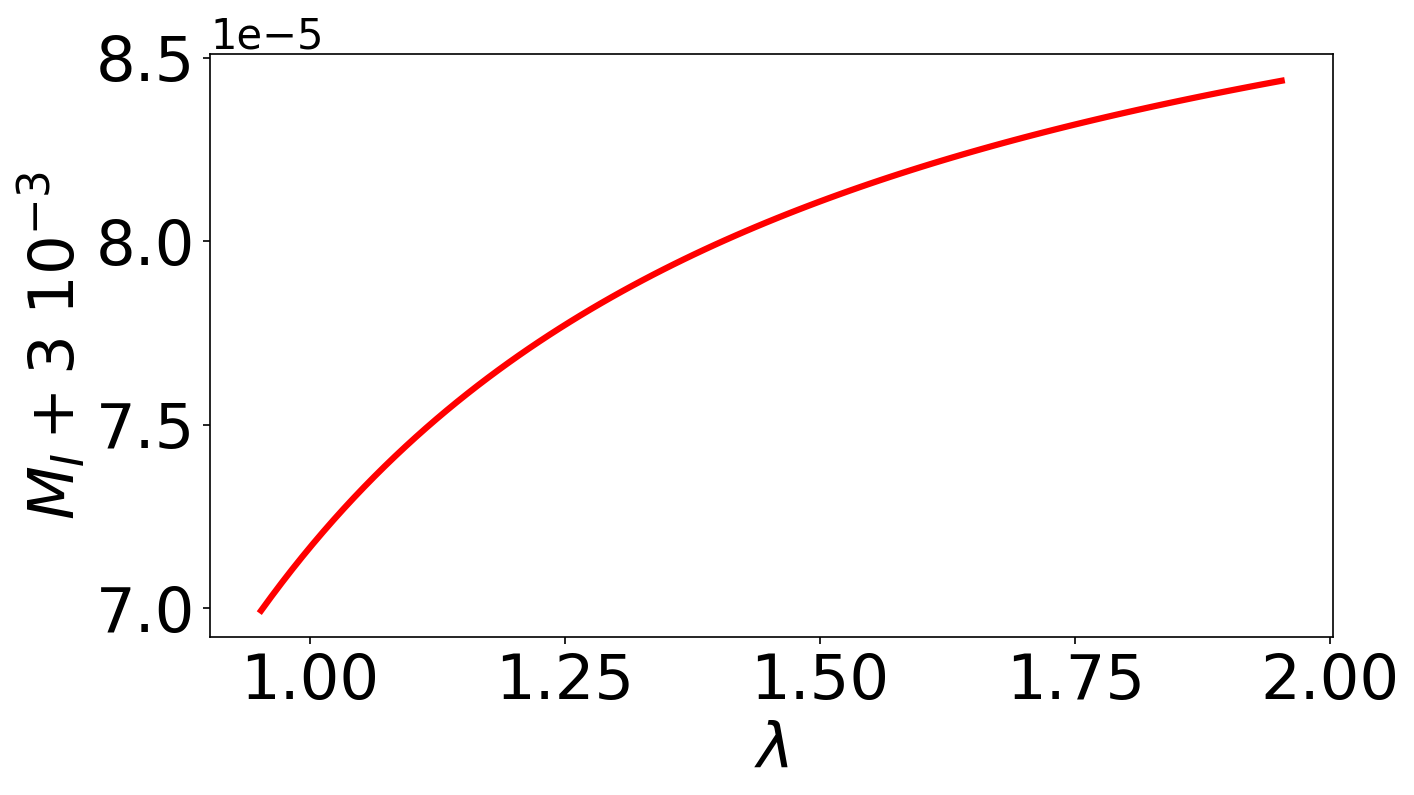

In [ ]:
plt.figure('M4', figsize=(10, 6), dpi = 150)
plt.plot(np.sqrt(lams)/ Factor_l, M4*10000, '-r', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$10^4\ M_{\rho 1}$')
plt.yticks(fontsize=30)
plt.tight_layout()

plt.figure('M5', figsize=(10, 6), dpi = 150)
plt.plot(np.sqrt(lams)/ Factor_l, M5*1000, '-b', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$10^3\ M_{\rho 2}$')
plt.yticks(fontsize=30)
plt.tight_layout()

plt.figure('M6', figsize=(10, 6), dpi = 150)
plt.plot(np.sqrt(lams)/ Factor_l, M6+3e-3, '-r', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$M_I+3\ 10^{-3}$')
plt.yticks(fontsize=30)
plt.tight_layout(); plt.show()

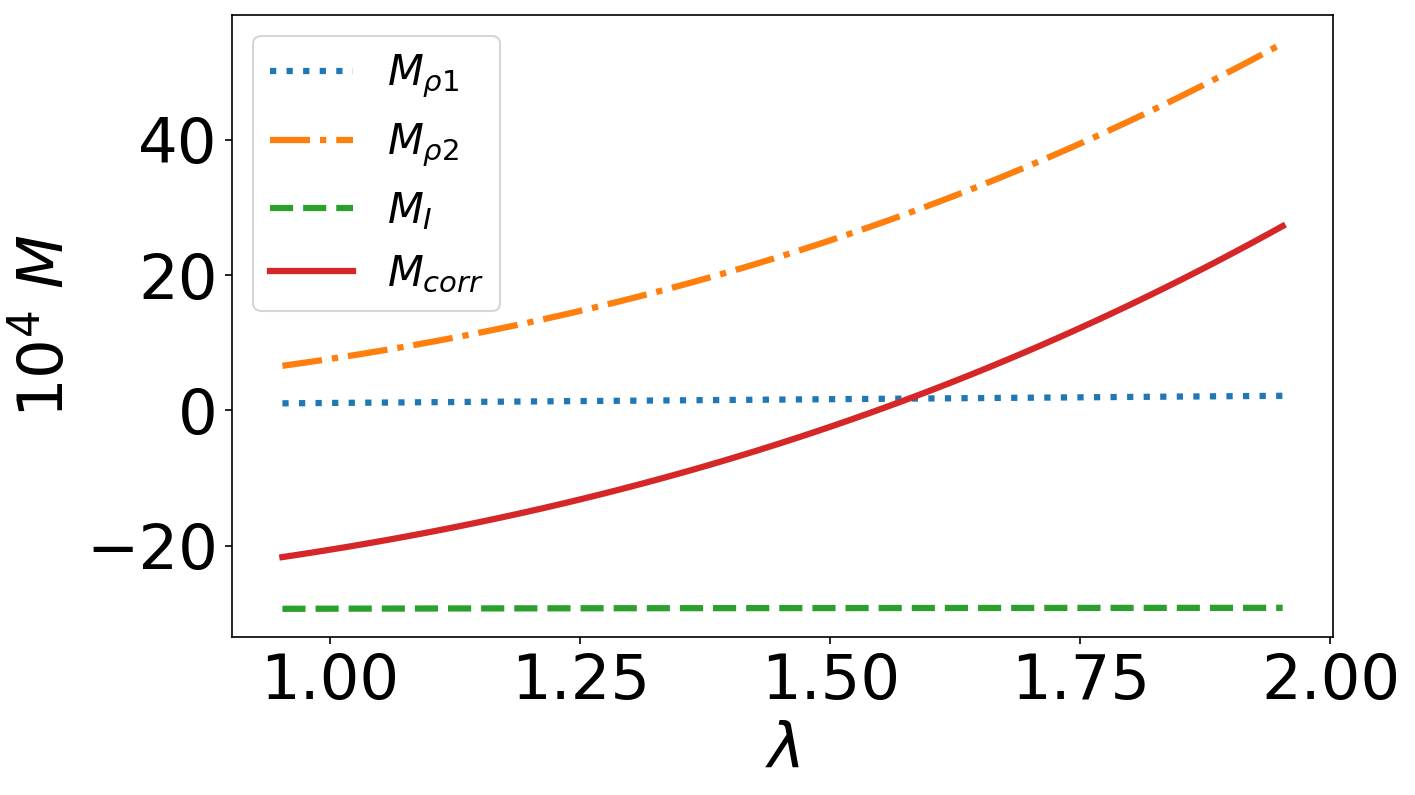

In [ ]:
plt.figure('Masas', figsize=(10, 6), dpi=150)
plt.plot(np.sqrt(lams)/ Factor_l, M4*10000, ':', linewidth=3, label=r'$M_{\rho 1}$')
plt.plot(np.sqrt(lams)/ Factor_l, M5*10000, '-.', linewidth=3, label=r'$M_{\rho 2}$')
plt.plot(np.sqrt(lams)/ Factor_l, M6*10000, '--', linewidth=3, label=r'$M_I$')
plt.plot(np.sqrt(lams)/ Factor_l, (M4+M5+M6)*10000, '-', linewidth=3, label=r'$M_{corr}$')

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$10^4\ M$')
plt.legend(loc='upper left', fontsize=20)
plt.yticks(fontsize=30)
plt.tight_layout(); plt.show()

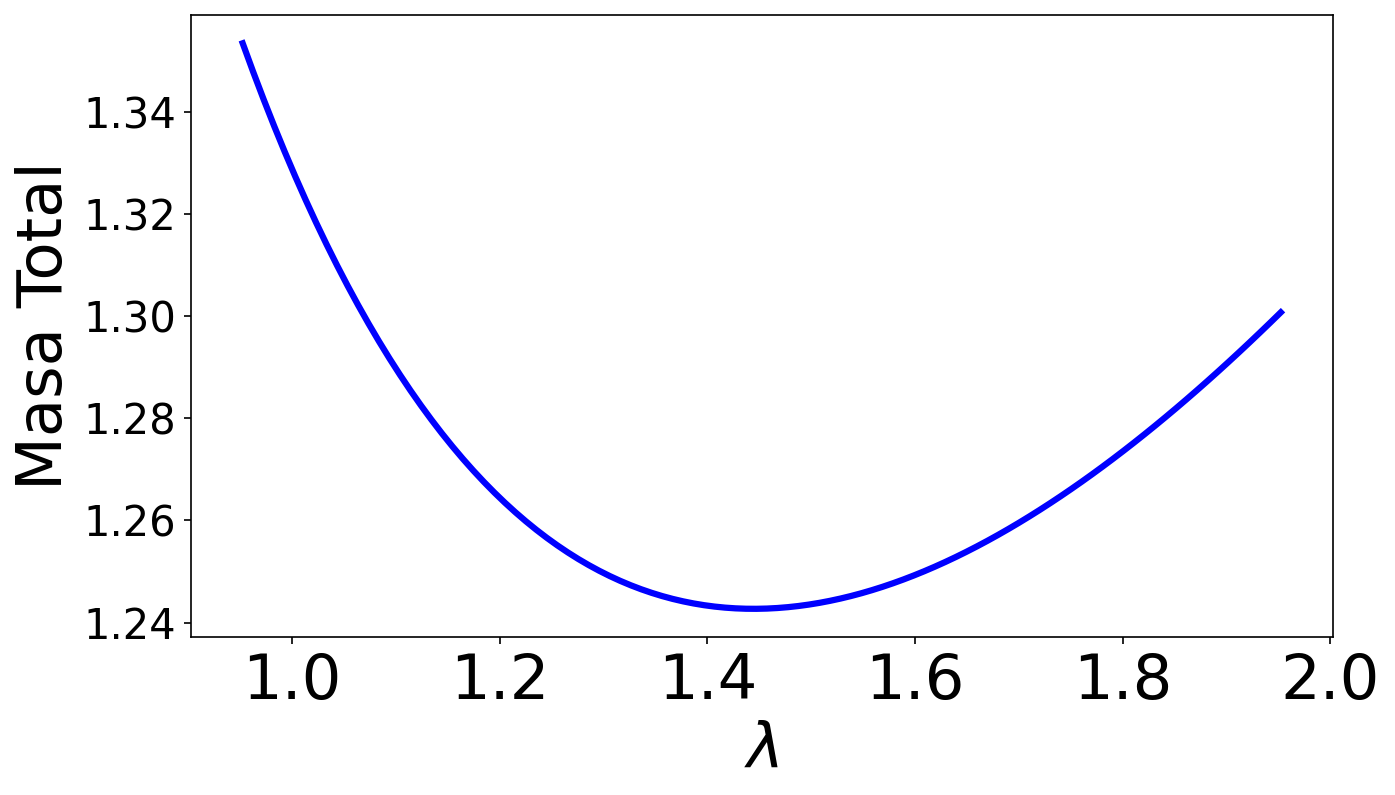

In [ ]:
plt.figure('Masas', figsize=(10, 6), dpi=150)
plt.plot(np.sqrt(lams)/ Factor_l, Masas_skyrme+M4+M5+M6, '-b', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel('Masa Total')
plt.tight_layout(); plt.show()

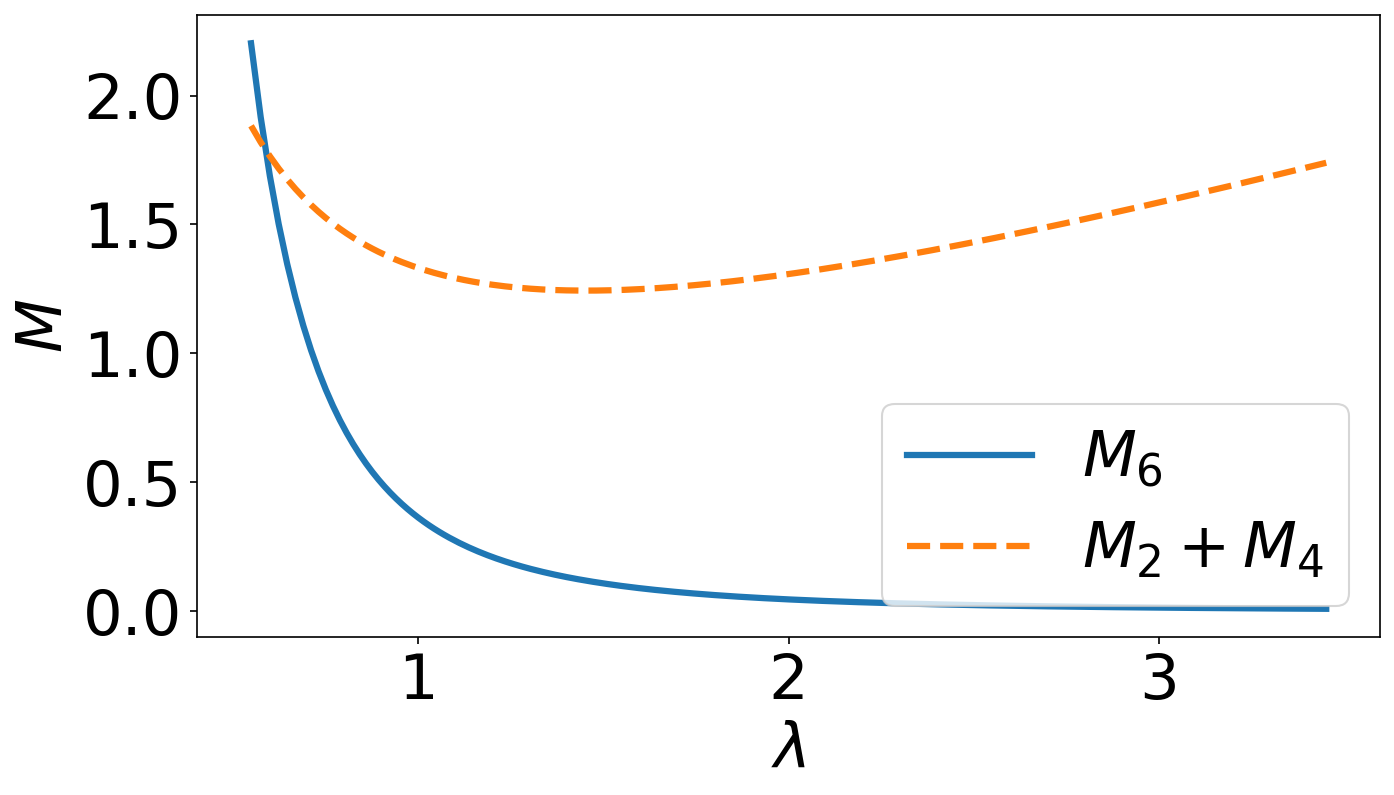

In [ ]:
plt.figure('M7', figsize=(10, 6), dpi=150)
plt.plot(np.sqrt(lams2)/ Factor_l, Masas_7, '-', linewidth=3, label=r'$M_6$')
plt.plot(np.sqrt(lams2)/ Factor_l, Masas_skyrme2, '--', linewidth=3, label=r'$M_{2}+M_4$')

plt.xlabel(r'$\lambda$'); plt.ylabel('$M$')
plt.legend(loc='lower right')
plt.yticks(fontsize=30)
plt.tight_layout(); plt.show()

In [ ]:
MSkyrm6 = Masas_skyrme2+Masas_7

print('Minimo Skyrme=', min(Masas_skyrme))
print('Minimo Skyrme6=', min(MSkyrm6))

print('lam minimo Skyrme=', np.sqrt(lams[list(Masas_skyrme).index(min(Masas_skyrme))]) / Factor_l)
print('lam minimo Skyrme6=', np.sqrt(lams2[list(MSkyrm6).index(min(MSkyrm6))]) / Factor_l)
print('ultimo lambda = ', np.sqrt(lams2[-1]) / Factor_l)

Minimo Skyrme= 1.243206293091898
Minimo Skyrme6= 1.3321781981934426
lam minimo Skyrme= 1.4573065914619345
lam minimo Skyrme6= 1.7259408201528363
ultimo lambda =  3.4522560864114293


In [ ]:
Mtotal = Masas_skyrme+M4+M5+M6
MSkyrm6 = Masas_skyrme2+Masas_7

print('Minimo Rho=', min(Mtotal))
print('Minimo Skyrme=', min(Masas_skyrme))
print('Minimo Skyrme6=', min(MSkyrm6))

print('lam minimo Rho=', np.sqrt(lams[list(Mtotal).index(min(Mtotal))]) / Factor_l)
print('lam minimo Skyrme=', np.sqrt(lams[list(Masas_skyrme).index(min(Masas_skyrme))]) / Factor_l)
print('lam minimo Skyrme6=', np.sqrt(lams2[list(MSkyrm6).index(min(MSkyrm6))]) / Factor_l)

Minimo Rho= 1.242708325795009
Minimo Skyrme= 1.243206293091898
Minimo Skyrme6= 1.3321781981934426
lam minimo Rho= 1.4472055813609244
lam minimo Skyrme= 1.4573065914619345
lam minimo Skyrme6= 1.7259408201528363


Ahora vamos a movernos a lo largo de h mediante un parámetro H para ver cual es el cambio.

In [ ]:
'''n_H = 20
max_H = 10
H = np.linspace(0, max_H, n_H)
M_T = []
n_r = 5000 #5000
r_f = 30. #30
n_lam = 10
lam_f = np.sqrt(53.4570253 / (4*6.336630541)) + 0.01

rs = np.linspace(1e-6, r_f, n_r)* Factor_l
lams = np.linspace((lam_f-0.01*2)**2, lam_f**2, n_lam)* Factor_l**2

Masas_skyrme = np.array([Mskyrme(F_pi_val, _lam, m_pi, e_val) for _lam in lams])/Factor_e

plt.figure('Masas', figsize=(12, 6), dpi=150)
for i in range(n_H):
    k1_r_lam = np.array([ [ integrate.quad(lambda h: k1(h-H[i], r=rs[_r], lam=lams[_l]), -np.inf, np.inf, limit=200)[0] for _r in range(n_r) ] for _l in range(n_lam) ])
    k2_r_lam = np.array([ [ integrate.quad(lambda h: k2(h-H[i], r=rs[_r], lam=lams[_l]), -np.inf, np.inf, limit=200)[0] for _r in range(n_r) ] for _l in range(n_lam) ])
    k3_r_lam = np.array([ [ integrate.quad(lambda h: k3(h-H[i], r=rs[_r], lam=lams[_l]), -np.inf, np.inf, limit=200)[0] for _r in range(n_r) ] for _l in range(n_lam) ])

    M4 = np.array( [ integrador4(k1_r_lam[_], k2_r_lam[_], k3_r_lam[_], rs) for _ in range(n_lam) ] )/Factor_e
    M5 = m_rho**2 * np.array( [ integrador5(k1_r_lam[_], k2_r_lam[_], k3_r_lam[_], rs) for _ in range(n_lam) ] )/Factor_e
    M6 = alpha*np.array( [ integrador6(k3_r_lam[_], rs, lams[_]) for _ in range(n_lam) ] )/Factor_e

    M_T.append( M4+M5+M6 )
    plt.plot(np.sqrt(lams) / Factor_l, M_T[i], '-', label=r'$M_T$ con $H=${}'.format(H[i]))
    Mtotal = Masas_skyrme + M_T[i]
    print('Para H=', H[i], ' , el minimo es M=', min(Mtotal), ' en lam=', np.sqrt(lams[list(Mtotal).index(min(Mtotal))]) / Factor_l)

plt.xlabel(r'$\lambda$'); plt.xticks(fontsize=15); plt.ylabel('Masa corregida')
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout(); plt.show()'''

Ahora los momentos de inercia.

In [ ]:
@njit
def I12(F_pi_val, e_val, lam): return np.pi*np.sqrt(lam)/(e_val**2)*(9.982 + 516.357*F_pi_val**2*e_val**2*lam)
@njit
def I4(k1, k3, rs): return integrador5(k1, k3, rs)*(4./3.)
@njit
def MI6_dif(k3, dr, r, lam):
    a = np.sqrt(lam+r**2)
    return r*r*np.sin(np.pi*r/a)*k3*( np.sin(2.*np.pi*r/a)/r + 2.*np.pi*lam/a**3)
@njit
def integradorI6(k3, rs, lam):
    dr = rs[2] - rs[1]; M6 = 0
    for i in range(len(rs)): M6 += MI6_dif( k3[i], dr, rs[i], lam ) * dr
    return M6
@njit
def I6(alpha, k1, k3, lam, rs):
    return 32*np.pi/3 * alpha * integradorI6(k3, rs, lam)
@njit
def I7(F_pi_val, kappa_inv, lam): return 1.26611*np.pi**3 *kappa_inv**2/(np.sqrt(lam)*F_pi_val**2) 

In [ ]:
I__12 = np.array( [ I12(F_pi_val, e_val, lams[_]) for _ in range(n_lam) ] )
I__4 = np.array( [ I4(k1_r_lam[_], k3_r_lam[_], rs) for _ in range(n_lam) ] )
I__6 = np.array( [ integradorI6(k3_r_lam[_], rs, lams[_]) for _ in range(n_lam) ] )
I__7 = np.array( [ I7(F_pi_val, kapp_inv, lams[_]) for _ in range(n_lam) ] )
I__T1 = I__12 + I__4 + I__6
I__T2 = I__12 + I__7

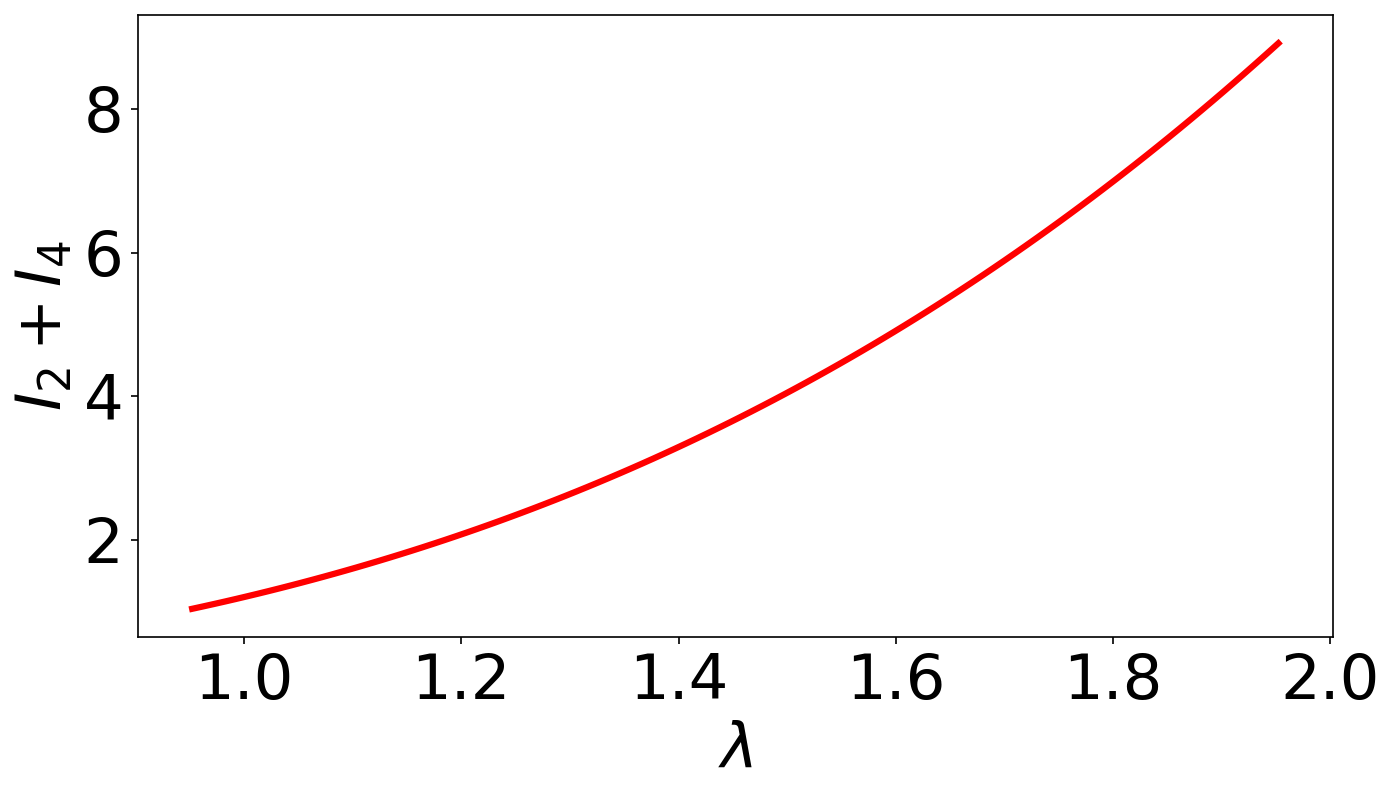

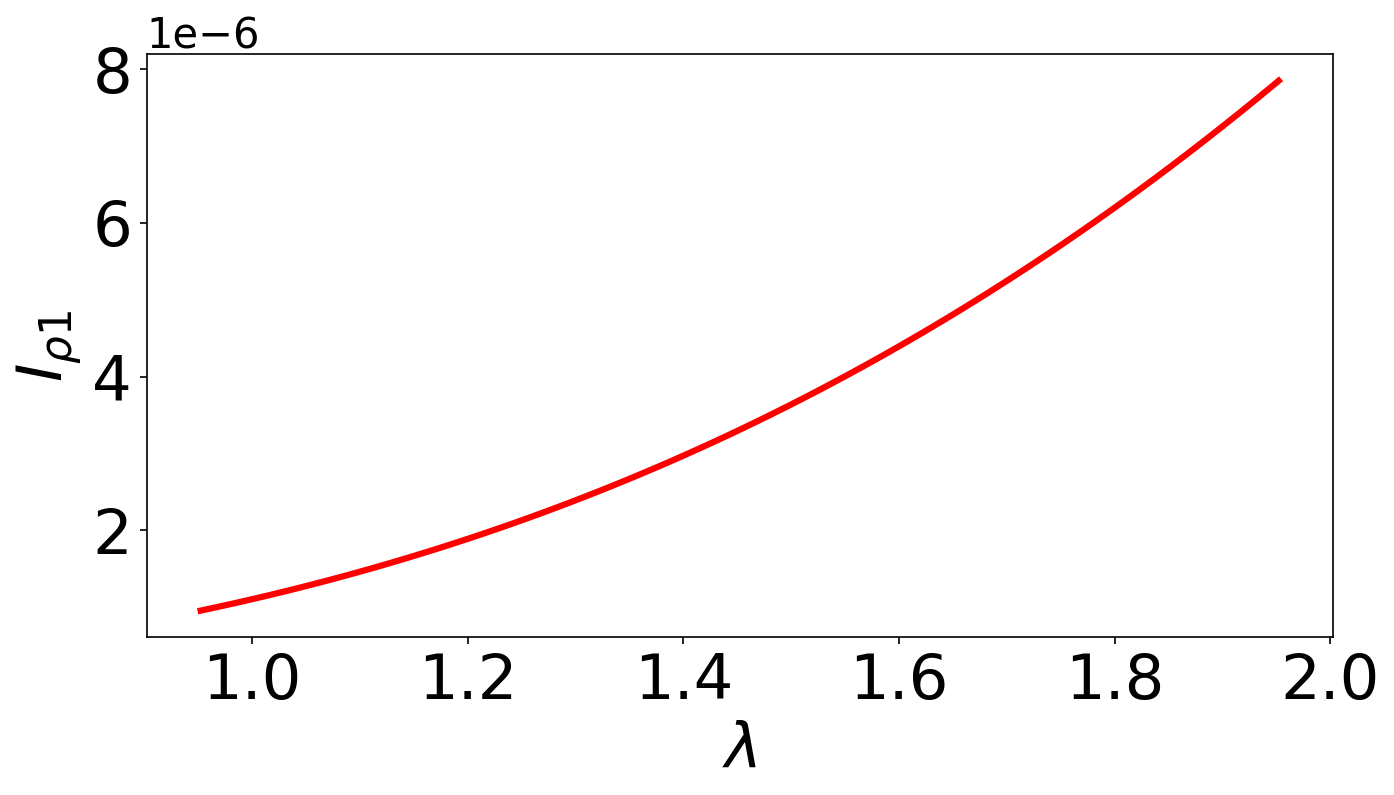

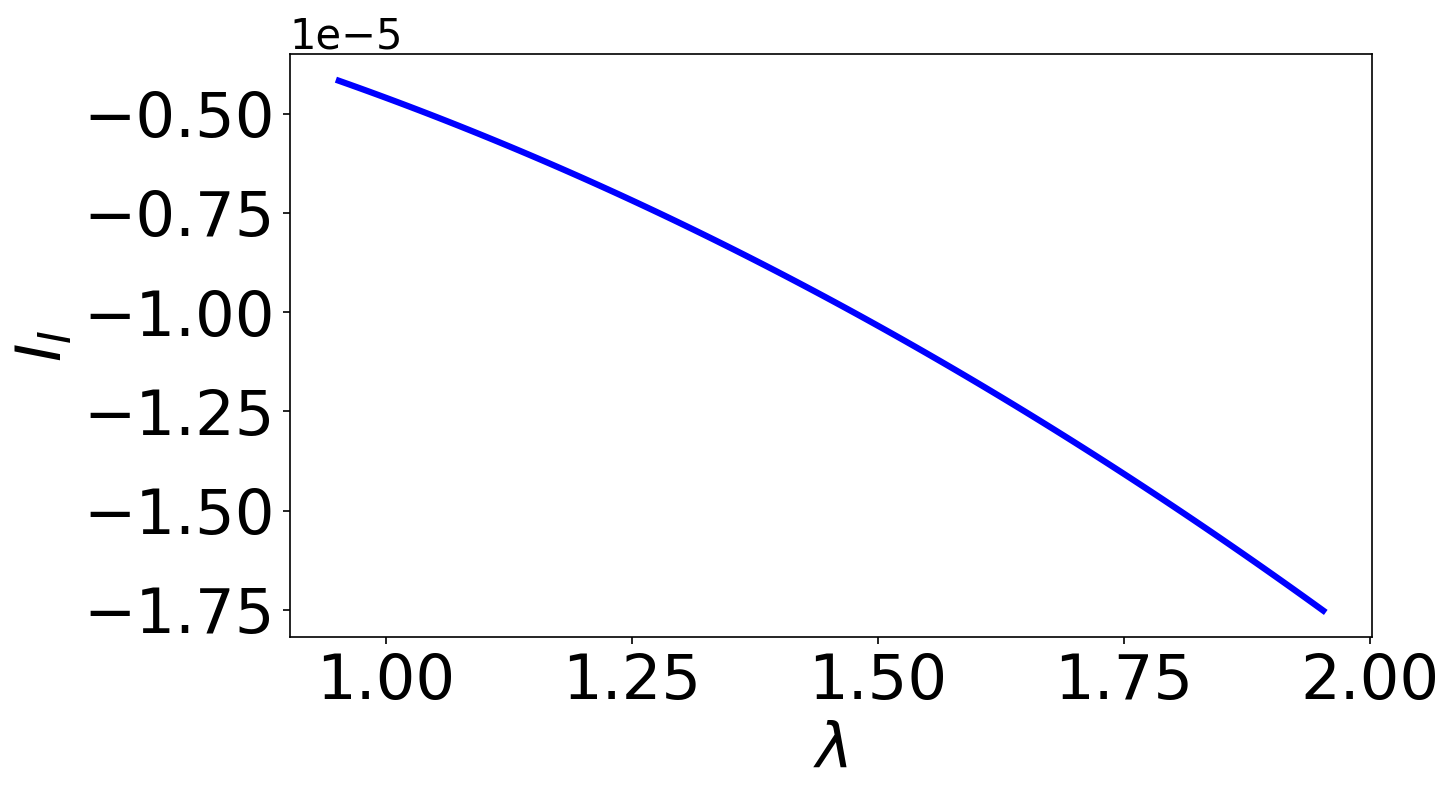

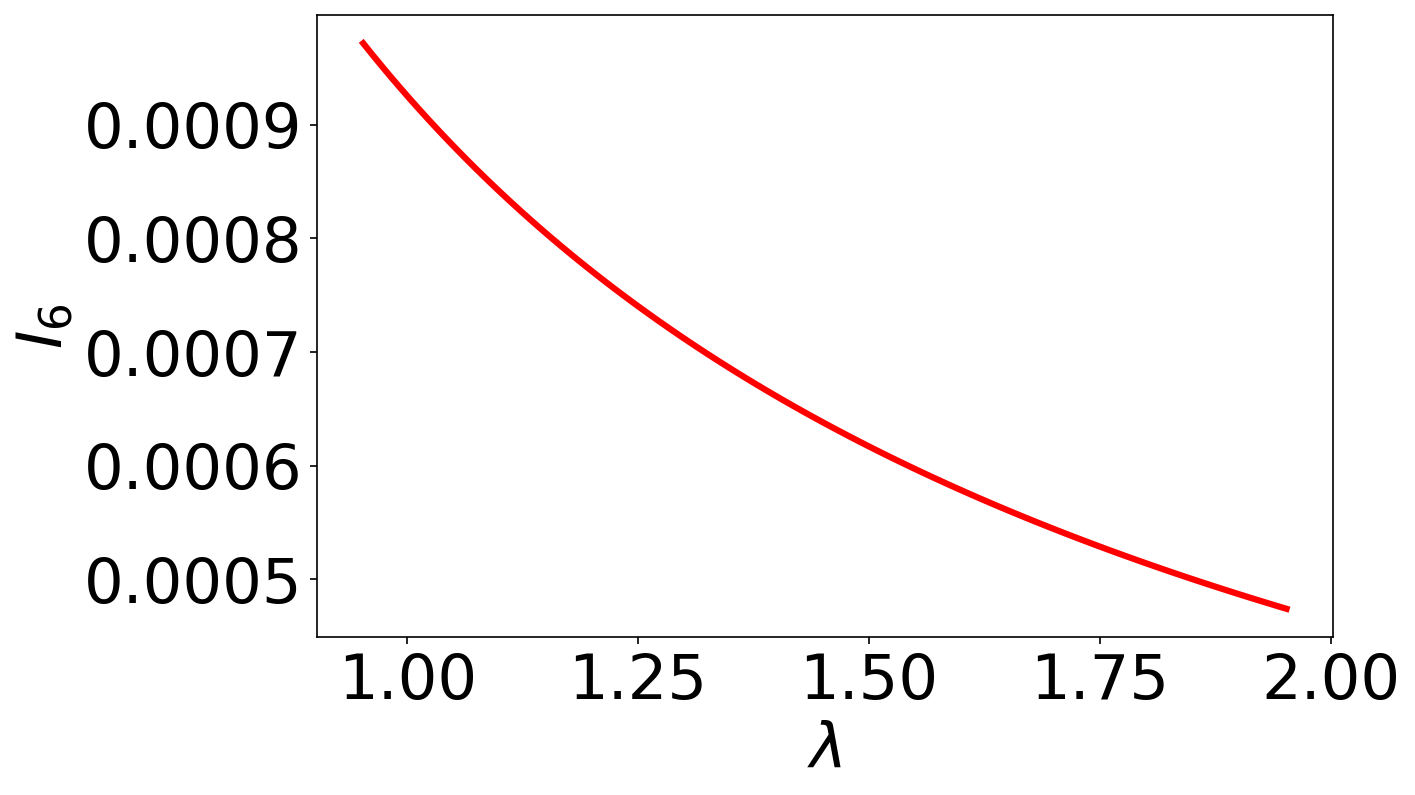

In [ ]:
plt.figure('I12', figsize=(10, 6), dpi = 150)
plt.plot(np.sqrt(lams)/ Factor_l, I__12, '-r', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$I_2+I_4$')
plt.yticks(fontsize=30)
plt.tight_layout()

plt.figure('I4', figsize=(10, 6), dpi = 150)
plt.plot(np.sqrt(lams)/ Factor_l, I__4, '-r', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$I_{\rho 1}$')
plt.yticks(fontsize=30)
plt.tight_layout()

plt.figure('I6', figsize=(10, 6), dpi = 150)
plt.plot(np.sqrt(lams)/ Factor_l, I__6, '-b', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$I_I$')
plt.yticks(fontsize=30)
plt.tight_layout()

plt.figure('I7', figsize=(10, 6), dpi = 150)
plt.plot(np.sqrt(lams)/ Factor_l, I__7, '-r', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$I_6$')
plt.yticks(fontsize=30)
plt.tight_layout(); plt.show()

In [ ]:
@njit
def dens_I_sk(F_pi_val, e_val, lam, r):
    a = np.sqrt(r*r+lam)
    return 8 *np.pi/(3*e_val**2)* np.sin(np.pi*r/a)**2 *(np.sin(np.pi*r/a)**2/r**2 + np.pi**2 *lam**2 /a**6 + (F_pi_val*e_val/2)**2)*r*r
@njit
def dens_I_4(k1, k3, r): return 4/3 *M5_dif(k1, k3, r)
@njit
def dens_I_6(k3, alpha, lam, r):
    a = np.sqrt(r*r+lam)
    return 32*np.pi/3 *alpha *r*r*np.sin(np.pi*r/a)*k3*(np.sin(2*np.pi*r/a)/r + 2*np.pi*lam/a**3)
@njit
def dens_I_7(F_pi_val, kapp_inv, lam, r):
    a = np.sqrt(r*r+lam)
    return 16*np.pi**3*kapp_inv*lam**2 /3 *np.sin(np.pi*r/a)/a**6

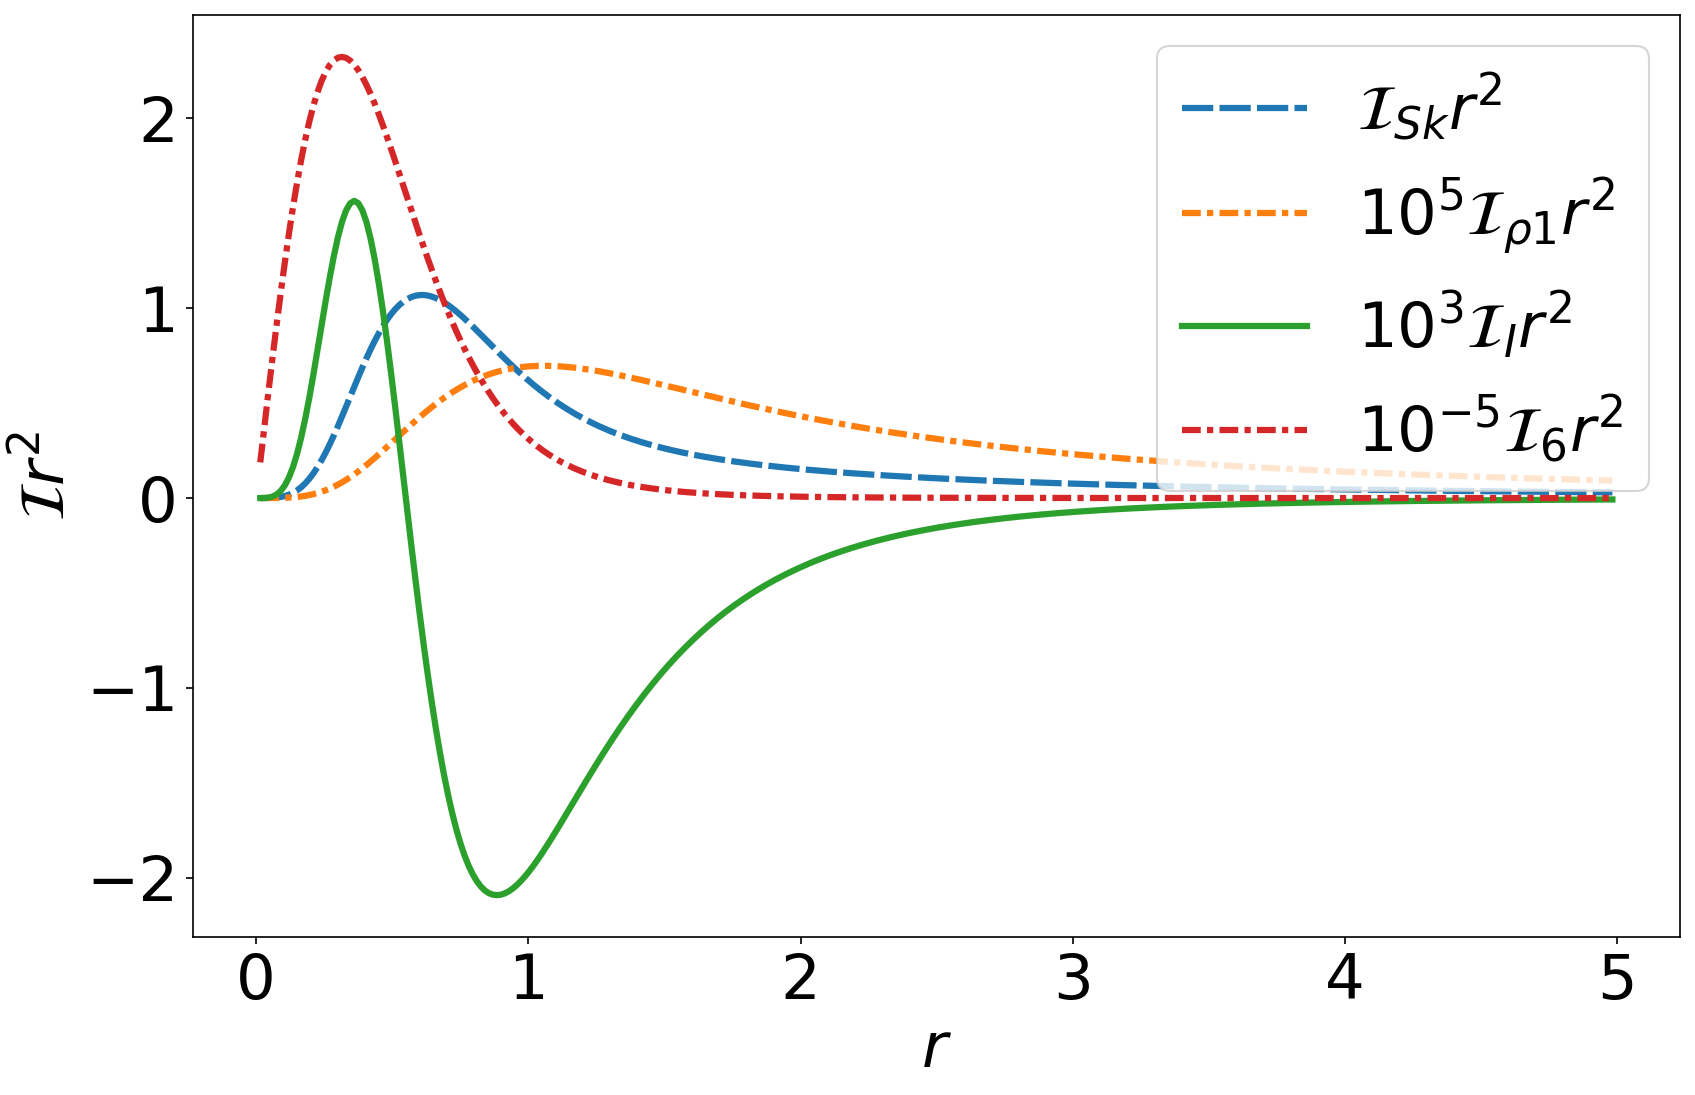

In [ ]:
dens_I__12 = np.array( [ dens_I_sk(F_pi_val, e_val, lams3[0], _r) for _r in rs2 ] )
dens_I__4 = np.array( [ dens_I_4(k1_r_lam2[0][_r], k3_r_lam2[0][_r], rs2[_r]) for _r in range(len(rs2)) ] )
dens_I__6 = np.array( [ dens_I_6(k3_r_lam2[0][_r], alpha, lams3[0],  rs2[_r]) for _r in range(len(rs2)) ] )
dens_I__7 = np.array( [ dens_I_7(F_pi_val, kapp_inv, lams3[0], rs2[_r]) for _r in range(len(rs2)) ] )

plt.figure('Ii frente a r', figsize=(12, 8), dpi = 150)
plt.plot(rs2[1:int(len(rs2)/6)] / Factor_l, dens_I__12[1:int(len(rs2)/6)], linestyle=(0, (5, 1)), label=r'$\mathcal{I}_{Sk} r^2$', linewidth=3)
plt.plot(rs2[1:int(len(rs2)/6)] / Factor_l, dens_I__4[1:int(len(rs2)/6)]*10**5, linestyle=(0, (3, 1, 1, 1)), label=r'$10^5 \mathcal{I}_{\rho 1} r^2$', linewidth=3)

plt.plot(rs2[1:int(len(rs2)/6)] / Factor_l, dens_I__6[1:int(len(rs2)/6)]*10**3, '-',label=r'$10^3 \mathcal{I}_I r^2$', linewidth=3)
plt.plot(rs2[1:int(len(rs2)/6)] / Factor_l, dens_I__7[1:int(len(rs2)/6)]/10**5, linestyle=(0, (3, 1, 1, 1)), label=r'$10^{-5} \mathcal{I}_6 r^2$', linewidth=3)

plt.xlabel(r'$r$'); plt.ylabel(r'$\mathcal{I} r^2$')
plt.yticks(fontsize=30)
plt.legend(loc='upper right', fontsize = 30)
plt.tight_layout(); plt.show()

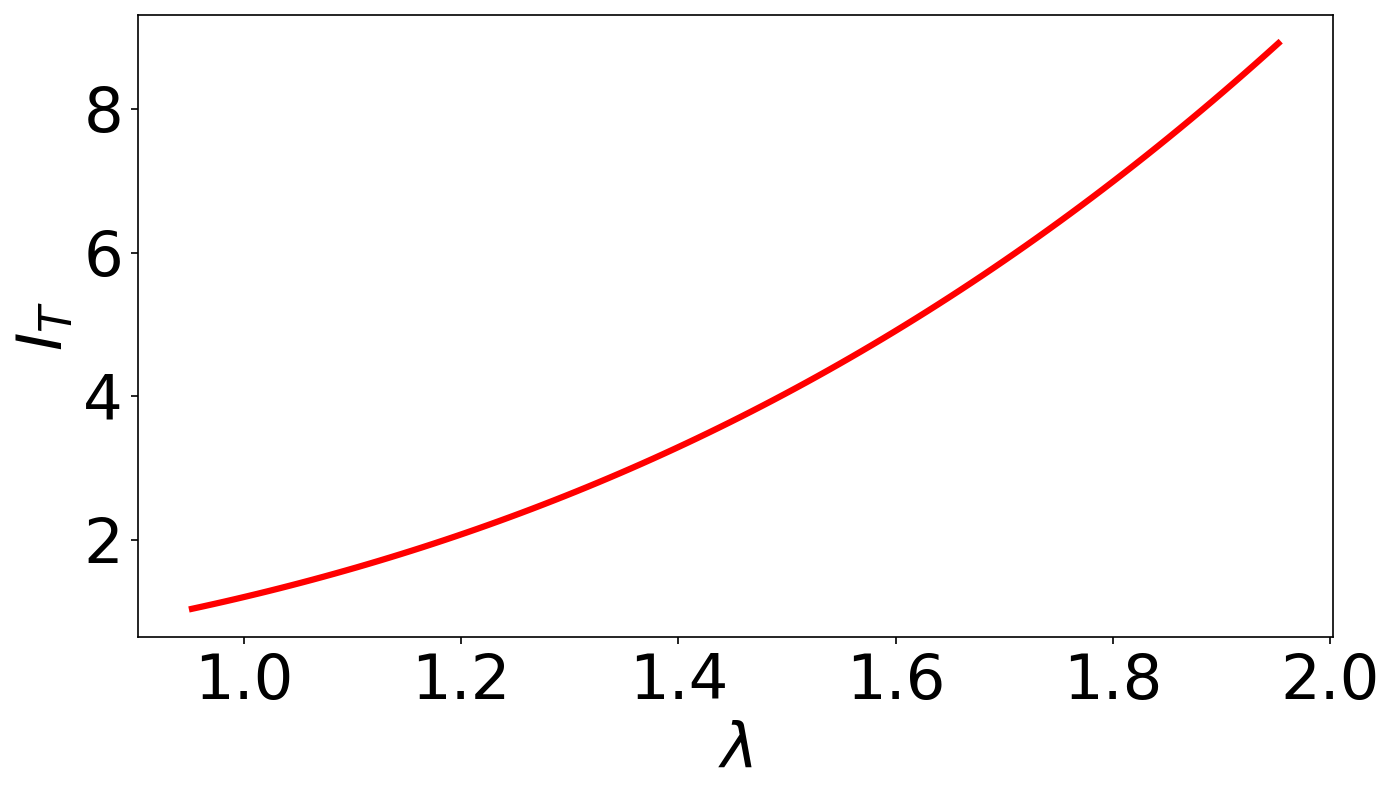

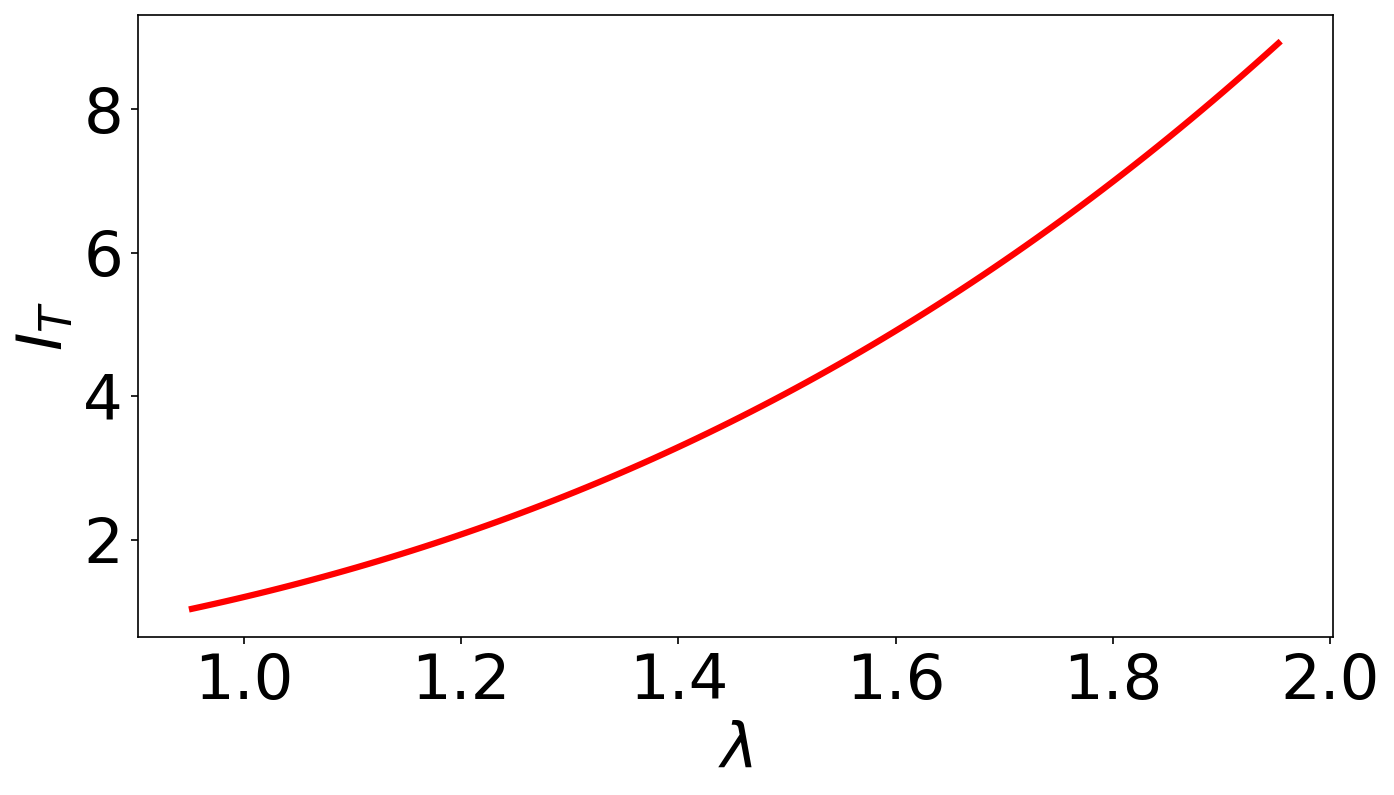

In [ ]:
plt.figure('IT1', figsize=(10, 6), dpi = 150)
plt.plot(np.sqrt(lams)/ Factor_l, I__T1, '-r', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$I_T$')
plt.yticks(fontsize=30)
plt.tight_layout()

plt.figure('IT2', figsize=(10, 6), dpi = 150)
plt.plot(np.sqrt(lams)/ Factor_l, I__T2, '-r', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$I_T$')
plt.yticks(fontsize=30)
plt.tight_layout()

In [ ]:
@njit
def rbar(lam): return 0.55718 * lam
@njit
def r_cuad_med_bar(lam, convers): return np.sqrt(rbar(lam))/convers *10**15 #Convertimos a fm

@njit
def rmagn(lam): return 1.809321 * lam 
@njit
def r_cuad_med_magn(lam, convers): return np.sqrt(rmagn(lam))/convers *10**15 #Convertimos a fm

Masa neutronrho:  925.93  MeV
Masa deltarho:  1209.79  MeV
Masa neutron6:  958.82  MeV
Masa delta6:  1128.02  MeV

Radio barrho:  0.85  fm
Radio magnrho:  1.53  fm
Radio bar6:  1.01  fm
Radio magn6:  1.82  fm

mmag_prho:  2.17
mmag_nrho:  -1.09
mmag_p6:  3.3
mmag_n6:  -2.36


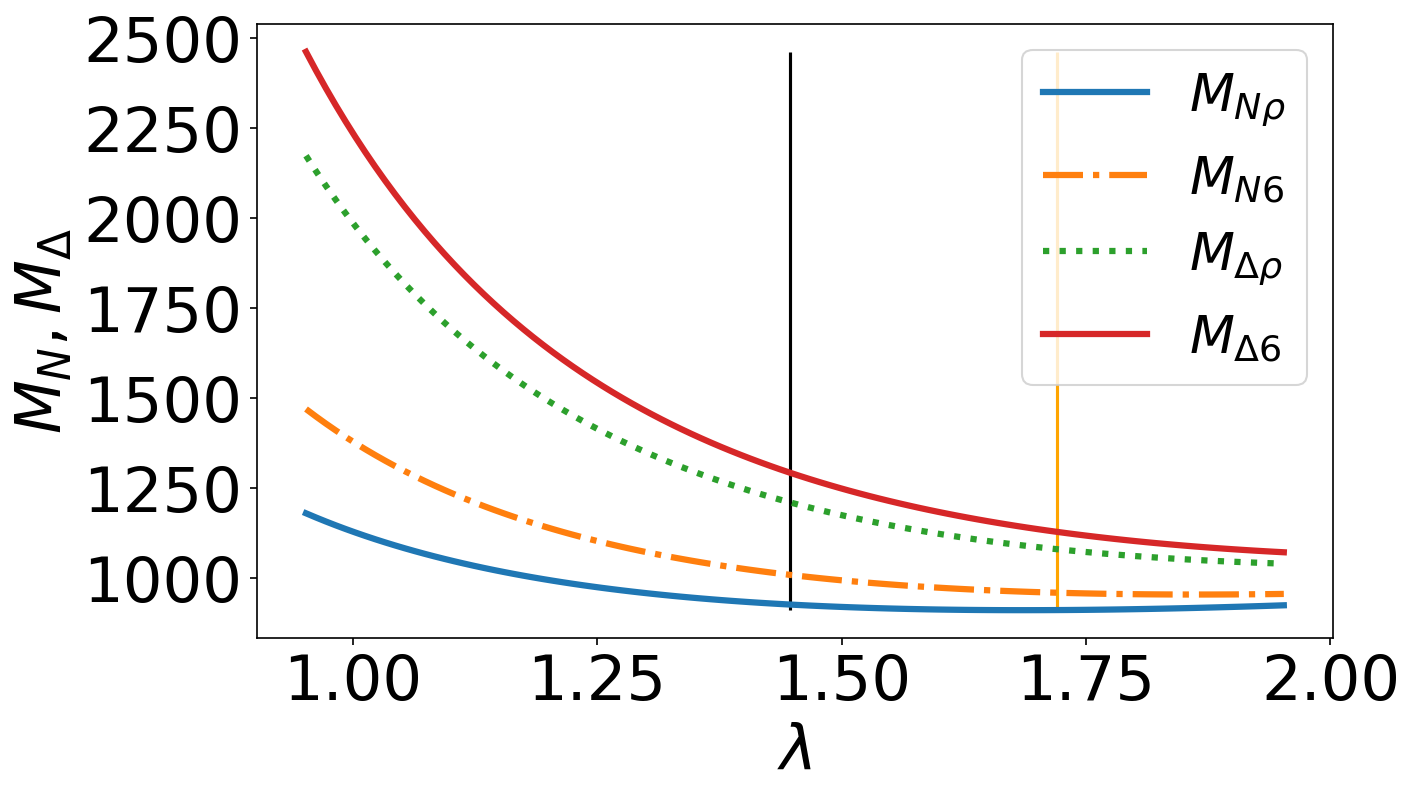

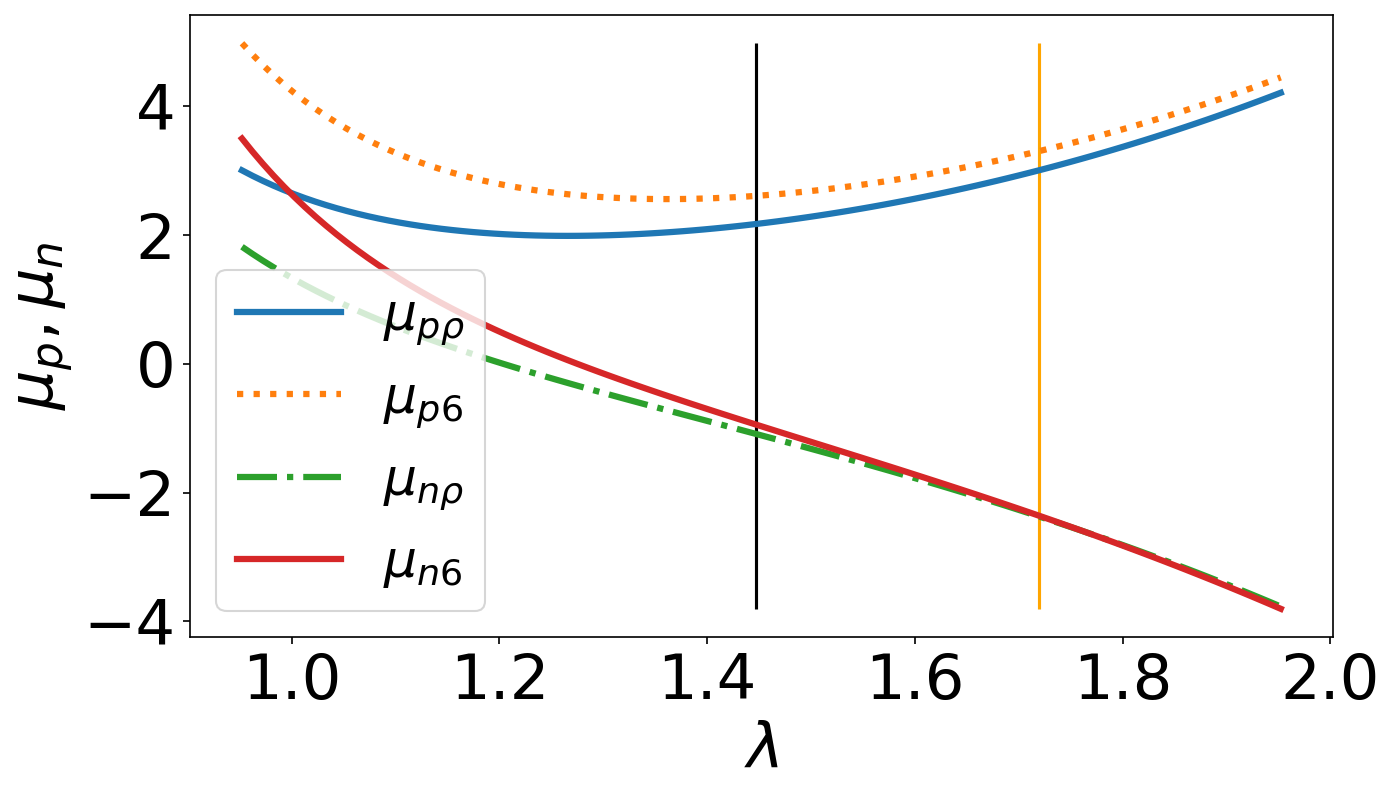

In [ ]:
Masas_72 = np.array([M7(F_pi_val, _lam, kapp_inv) for _lam in lams])
MSkyrm62 = Masas_skyrme*Factor_e+Masas_72

index1 = list(Mtotal).index(min(Mtotal))
index2 = list(MSkyrm62).index(min(MSkyrm62))

lam_min1 = lams[index1]
lam_min2 = lams[index2]

M_N1 = (Mtotal*Factor_e + 3./(8.*I__T1)*Factor_e)
M_D1 = (Mtotal*Factor_e + 15./(8.*I__T1)*Factor_e)

M_N2 = (MSkyrm62 + 3./(8.*I__T2)*Factor_e)
M_D2 = (MSkyrm62 + 15./(8.*I__T2)*Factor_e)

r_bar1 = r_cuad_med_bar(lam_min1, convers)
r_magn1 = r_cuad_med_magn(lam_min1, convers)

r_bar2 = r_cuad_med_bar(lam_min2, convers)
r_magn2 = r_cuad_med_magn(lam_min2, convers)

m_magn_p1 = M_N1/3*((r_bar1*convers *10**-15)**2/(2*I__T1)*Factor_e + I__T1/Factor_e)
m_magn_n1 = M_N1/3*((r_bar1*convers *10**-15)**2/(2*I__T1)*Factor_e - I__T1/Factor_e)

m_magn_p2 = M_N2/3*((r_bar2*convers *10**-15)**2/(2*I__T2)*Factor_e + I__T2/Factor_e)
m_magn_n2 = M_N2/3*((r_bar2*convers *10**-15)**2/(2*I__T2)*Factor_e - I__T2/Factor_e)

plt.figure('M_ND', figsize=(10, 6), dpi = 150)
plt.vlines(np.sqrt(lams[index1])/ Factor_l, min(M_N1), max(M_D2), color='black')
plt.vlines(np.sqrt(lams[index2])/ Factor_l, min(M_N1), max(M_D2), color='orange')
plt.plot(np.sqrt(lams)/ Factor_l, M_N1, '-', linewidth=3, label=r'$M_{N \rho}$')
plt.plot(np.sqrt(lams)/ Factor_l, M_N2, '-.', linewidth=3, label=r'$M_{N6}$')
plt.plot(np.sqrt(lams)/ Factor_l, M_D1, ':', linewidth=3, label=r'$M_{\Delta \rho}$')
plt.plot(np.sqrt(lams)/ Factor_l, M_D2, '-', linewidth=3, label=r'$M_{\Delta 6}$')

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$M_N, M_\Delta$')
plt.yticks(fontsize=30)
plt.legend(loc='upper right', fontsize=25)
plt.tight_layout()

plt.figure('mu_np', figsize=(10, 6), dpi = 150)
plt.vlines(np.sqrt(lams[index1])/ Factor_l, min(m_magn_n2), max(m_magn_p2), color='black')
plt.vlines(np.sqrt(lams[index2])/ Factor_l, min(m_magn_n2), max(m_magn_p2), color='orange')
plt.plot(np.sqrt(lams)/ Factor_l, m_magn_p1, '-', linewidth=3, label=r'$\mu_{p\rho}$')
plt.plot(np.sqrt(lams)/ Factor_l, m_magn_p2, ':', linewidth=3, label=r'$\mu_{p6}$')
plt.plot(np.sqrt(lams)/ Factor_l, m_magn_n1, '-.', linewidth=3, label=r'$\mu_{n\rho}$')
plt.plot(np.sqrt(lams)/ Factor_l, m_magn_n2, '-', linewidth=3, label=r'$\mu_{n6}$')

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$\mu_p, \mu_n$')
plt.yticks(fontsize=30)
plt.legend(loc='lower left', fontsize=25)
plt.tight_layout()


print('Masa neutronrho: ', round(M_N1[index1], 2), ' MeV')
print('Masa deltarho: ', round(M_D1[index1], 2), ' MeV')
print('Masa neutron6: ', round(M_N2[index2], 2), ' MeV')
print('Masa delta6: ', round(M_D2[index2], 2), ' MeV')
print()

print('Radio barrho: ', round(r_bar1, 2), ' fm')
print('Radio magnrho: ', round(r_magn1, 2), ' fm')
print('Radio bar6: ', round(r_bar2, 2), ' fm')
print('Radio magn6: ', round(r_magn2, 2), ' fm')
print()

print('mmag_prho: ', round(m_magn_p1[index1], 2))
print('mmag_nrho: ', round(m_magn_n1[index1], 2))
print('mmag_p6: ', round(m_magn_p2[index2], 2))
print('mmag_n6: ', round(m_magn_n2[index2], 2))